# Feature Importance Analysis for Traffic Severity

This notebook identifies which parameters contribute most to traffic accident severity using various feature importance techniques.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Load the data
df = pd.read_csv('../data/processed/engineeredParams/part-00000-8480a262-db60-42e9-80f1-2a6fa0c73693-c000.csv')
print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {list(df.columns)}")
print(f"\nFirst few rows:")
df.head()


KeyboardInterrupt: 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)


## 1. Load and Explore Data


In [ ]:
# Load the data
df = pd.read_csv('../data/processed/sample_df.csv')
print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {list(df.columns)}")
print(f"\nFirst few rows:")
df.head()


In [4]:
# Check severity distribution
print("Severity distribution:")
print(df['Severity'].value_counts().sort_index())
print(f"\nSeverity distribution percentage:")
print(df['Severity'].value_counts(normalize=True).sort_index() * 100)


Severity distribution:
Severity
1       16
2    11074
3     8906
4        4
Name: count, dtype: int64

Severity distribution percentage:
Severity
1     0.08
2    55.37
3    44.53
4     0.02
Name: proportion, dtype: float64


## 2. Data Preprocessing


In [5]:
# Select numerical features that might be relevant
numerical_features = [
    'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)', 
    'Visibility(mi)', 'Wind_Speed(mph)', 'Precipitation(in)', 'Distance(mi)'
]

# Select categorical features
categorical_features = [
    'Weather_Condition', 'Sunrise_Sunset', 'Civil_Twilight', 
    'Nautical_Twilight', 'Astronomical_Twilight'
]

# Binary features
binary_features = [
    'Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 
    'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 
    'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop'
]

# Combine all potential features
all_features = numerical_features + categorical_features + binary_features

# Check which features exist in the dataset
available_features = [f for f in all_features if f in df.columns]
print(f"Available features: {len(available_features)} out of {len(all_features)}")
print(f"\nMissing features: {set(all_features) - set(available_features)}")


Available features: 26 out of 26

Missing features: set()


In [6]:
# Prepare the dataset
# Start with numerical features
feature_df = df[available_features + ['Severity']].copy()

# Handle missing values - fill numerical with median, categorical with mode
for col in feature_df.columns:
    if col == 'Severity':
        continue
    if feature_df[col].dtype in ['int64', 'float64']:
        feature_df[col].fillna(feature_df[col].median(), inplace=True)
    else:
        feature_df[col].fillna(feature_df[col].mode()[0] if len(feature_df[col].mode()) > 0 else 'Unknown', inplace=True)

# Encode categorical variables
le_dict = {}
for col in categorical_features:
    if col in feature_df.columns:
        le = LabelEncoder()
        feature_df[col] = le.fit_transform(feature_df[col].astype(str))
        le_dict[col] = le

# Convert binary features to numeric if they're not already
for col in binary_features:
    if col in feature_df.columns:
        if feature_df[col].dtype == 'object':
            feature_df[col] = feature_df[col].astype(int)

print(f"Final dataset shape: {feature_df.shape}")
print(f"Missing values: {feature_df.isnull().sum().sum()}")


Final dataset shape: (20000, 27)
Missing values: 0


## 3. Correlation Analysis


Correlation with Severity (sorted by absolute value):
Junction                      :  0.0826
Weather_Condition             :  0.0334
Temperature(F)                :  0.0239
No_Exit                       :  0.0142
Sunrise_Sunset                :  0.0121
Railway                       :  0.0113
Civil_Twilight                :  0.0111
Visibility(mi)                :  0.0103
Nautical_Twilight             :  0.0095
Humidity(%)                   :  0.0052
Astronomical_Twilight         :  0.0049
Bump                          :  0.0047
Wind_Speed(mph)               :  0.0024
Pressure(in)                  : -0.0007
Precipitation(in)             : -0.0050
Traffic_Calming               : -0.0055
Roundabout                    : -0.0063
Distance(mi)                  : -0.0064
Wind_Chill(F)                 : -0.0199
Give_Way                      : -0.0322
Station                       : -0.0617
Amenity                       : -0.0744
Stop                          : -0.1275
Crossing                  

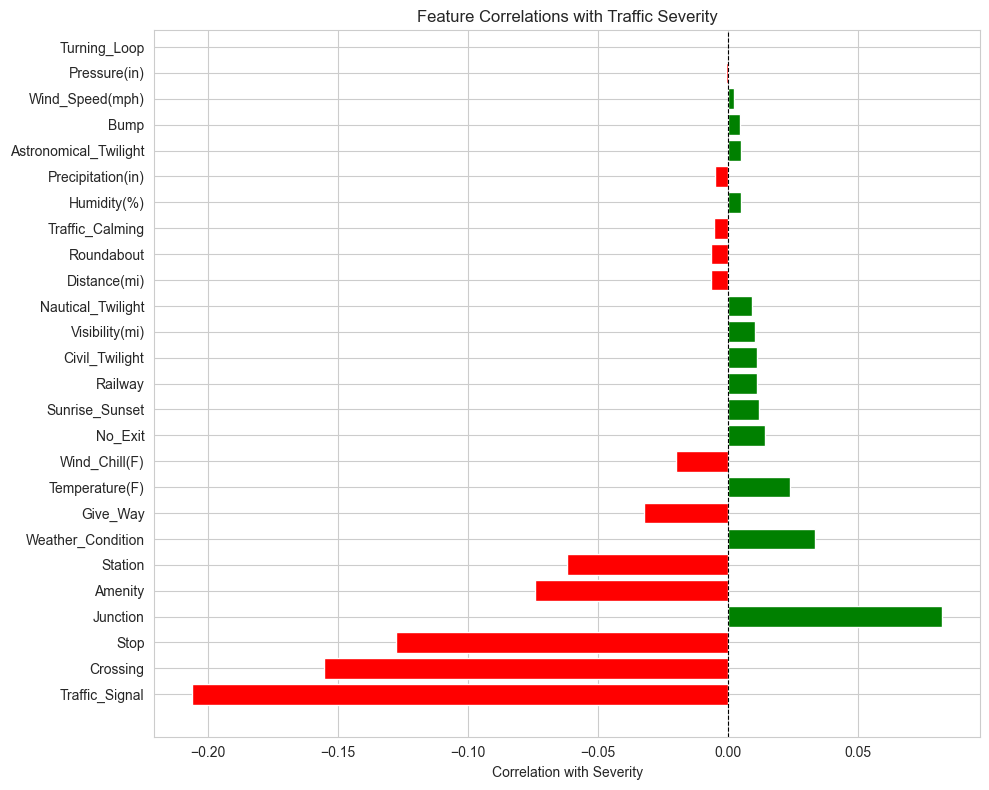

In [7]:
# Calculate correlation with severity
correlations = feature_df.corr()['Severity'].sort_values(ascending=False)
correlations = correlations.drop('Severity')  # Remove self-correlation

print("Correlation with Severity (sorted by absolute value):")
print("=" * 60)
for feature, corr in correlations.items():
    print(f"{feature:30s}: {corr:7.4f}")

# Visualize correlations
plt.figure(figsize=(10, 8))
correlations_sorted = correlations.reindex(correlations.abs().sort_values(ascending=False).index)
colors = ['red' if x < 0 else 'green' for x in correlations_sorted.values]
plt.barh(range(len(correlations_sorted)), correlations_sorted.values, color=colors)
plt.yticks(range(len(correlations_sorted)), correlations_sorted.index)
plt.xlabel('Correlation with Severity')
plt.title('Feature Correlations with Traffic Severity')
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
plt.tight_layout()
plt.show()


## 3.5. Visualizing How Parameters Affect Severity


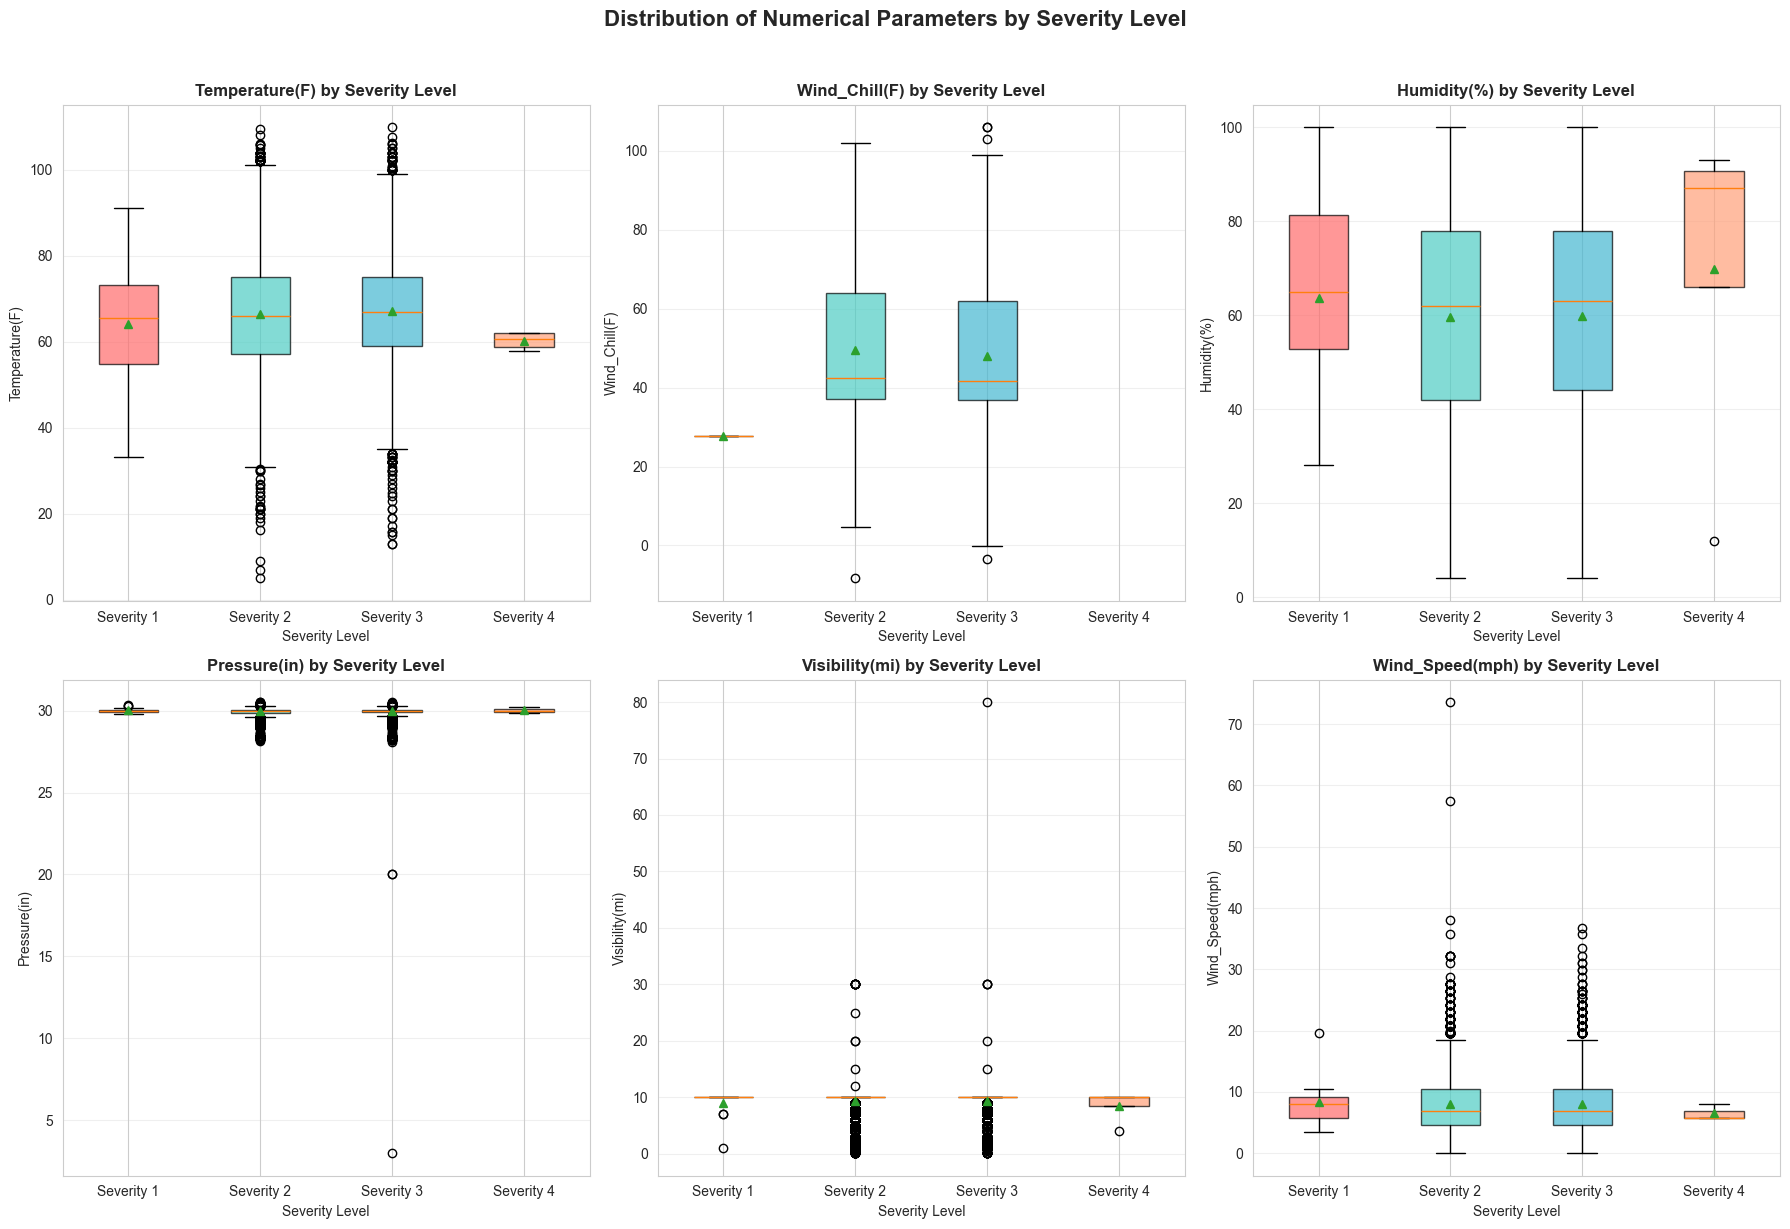

In [8]:
# Create comprehensive visualizations showing how parameters affect severity
# Focus on top numerical features
top_numerical = [f for f in numerical_features if f in df.columns][:6]  # Top 6 numerical features

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, feature in enumerate(top_numerical):
    # Prepare data for each severity level
    severity_levels = sorted(df['Severity'].dropna().unique())
    data_by_severity = [df[df['Severity'] == sev][feature].dropna() for sev in severity_levels]
    
    # Create box plot
    bp = axes[idx].boxplot(data_by_severity, labels=[f'Severity {int(s)}' for s in severity_levels], 
                          patch_artist=True, showmeans=True)
    
    # Color the boxes
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']
    for patch, color in zip(bp['boxes'], colors[:len(bp['boxes'])]):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    axes[idx].set_title(f'{feature} by Severity Level', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Severity Level')
    axes[idx].set_ylabel(feature)
    axes[idx].grid(True, alpha=0.3, axis='y')

plt.suptitle('Distribution of Numerical Parameters by Severity Level', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


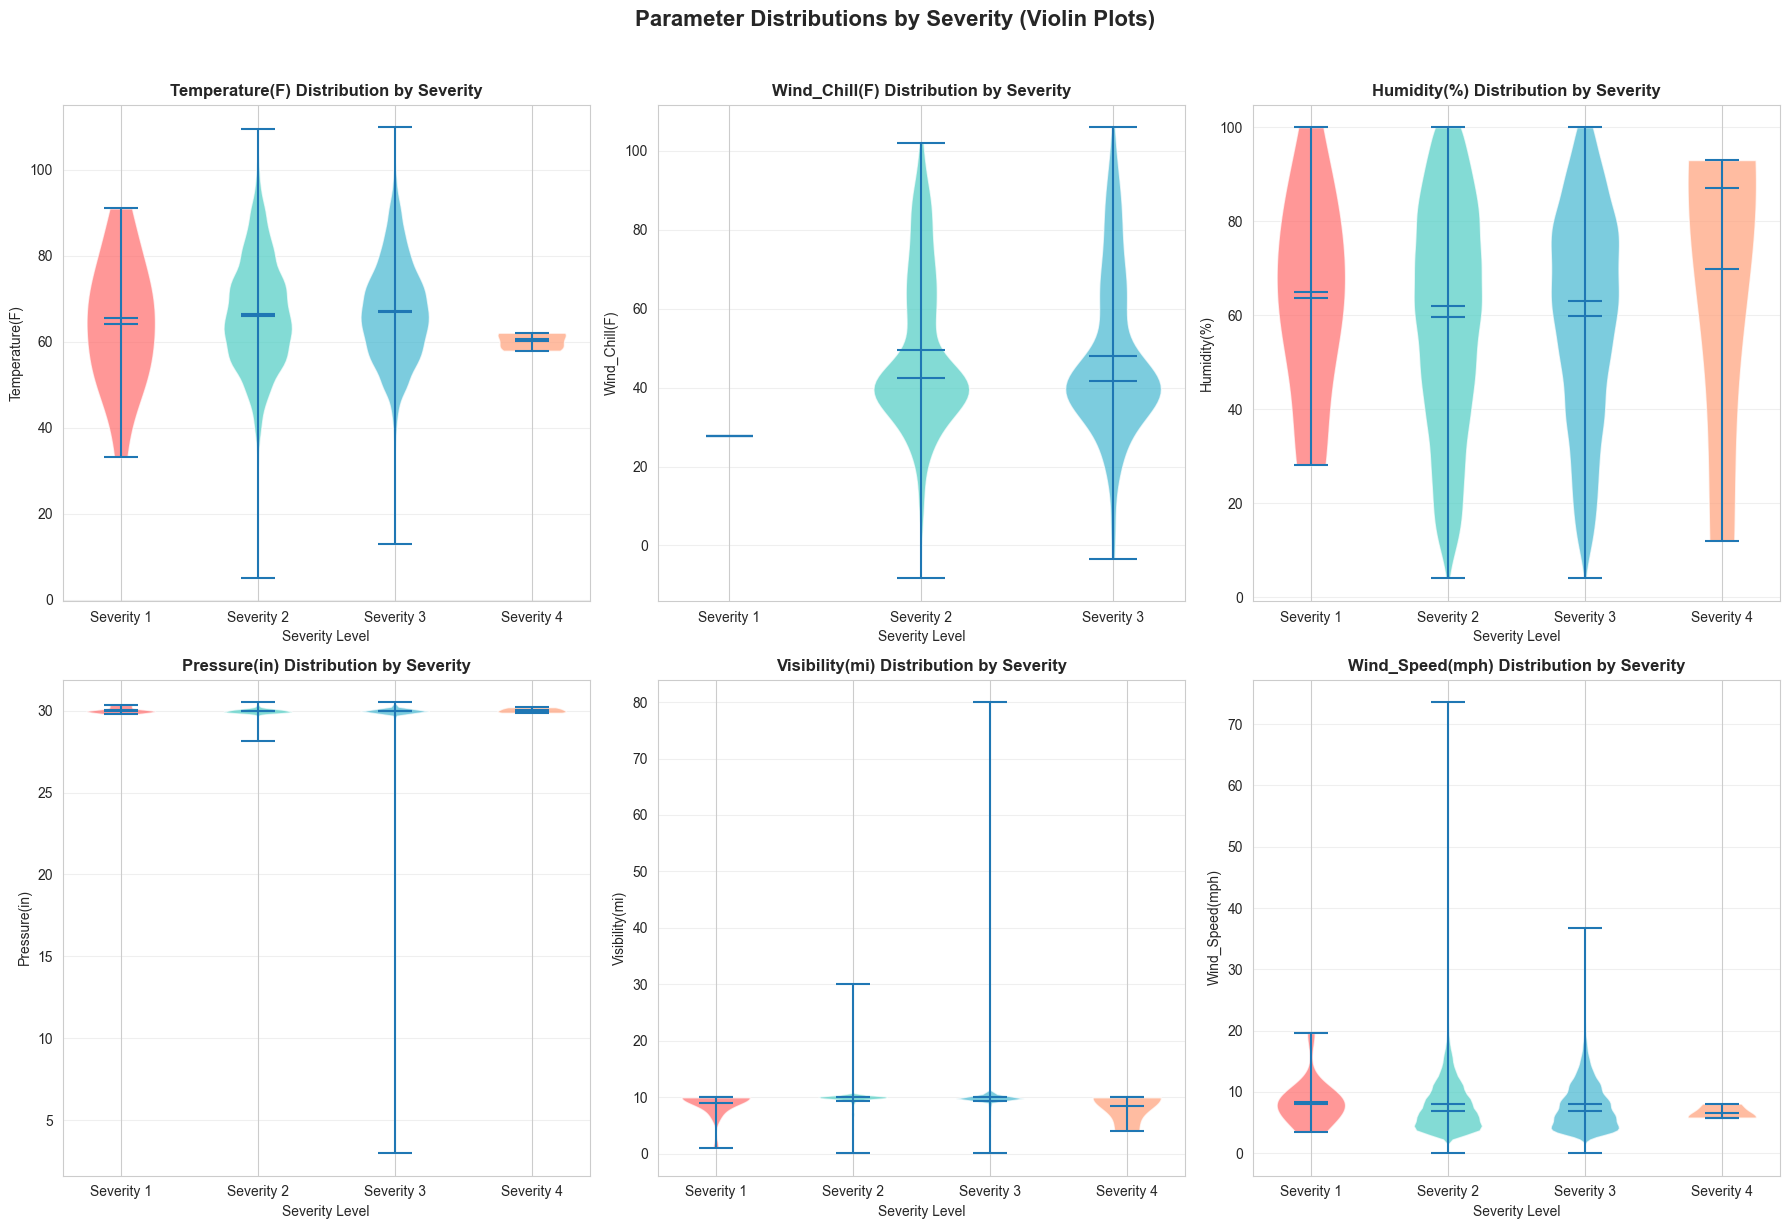

In [9]:
# Violin plots for better distribution visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, feature in enumerate(top_numerical):
    # Prepare data
    plot_data = []
    labels = []
    for severity in sorted(df['Severity'].dropna().unique()):
        data = df[df['Severity'] == severity][feature].dropna()
        if len(data) > 0:
            plot_data.append(data)
            labels.append(f'Severity {int(severity)}')
    
    # Create violin plot
    parts = axes[idx].violinplot(plot_data, positions=range(len(plot_data)), 
                                  showmeans=True, showmedians=True)
    
    # Customize colors
    for pc, color in zip(parts['bodies'], colors[:len(parts['bodies'])]):
        pc.set_facecolor(color)
        pc.set_alpha(0.7)
    
    axes[idx].set_xticks(range(len(labels)))
    axes[idx].set_xticklabels(labels)
    axes[idx].set_title(f'{feature} Distribution by Severity', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Severity Level')
    axes[idx].set_ylabel(feature)
    axes[idx].grid(True, alpha=0.3, axis='y')

plt.suptitle('Parameter Distributions by Severity (Violin Plots)', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


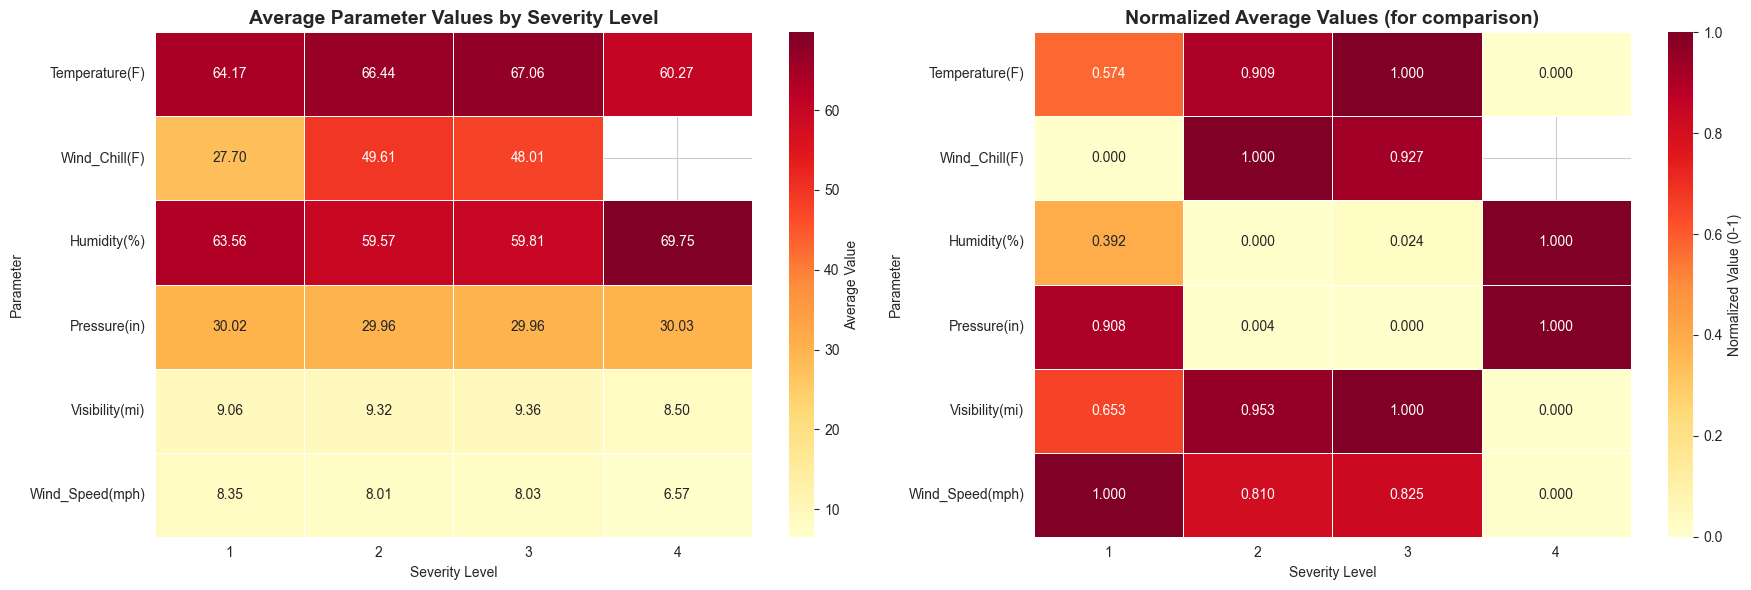

In [10]:
# Average parameter values by severity level
severity_levels = sorted(df['Severity'].dropna().unique())
avg_values = pd.DataFrame(index=severity_levels)

for feature in top_numerical:
    avg_values[feature] = [df[df['Severity'] == sev][feature].mean() for sev in severity_levels]

# Normalize for better comparison (0-1 scale)
avg_values_norm = avg_values.copy()
for col in avg_values_norm.columns:
    col_min = avg_values_norm[col].min()
    col_max = avg_values_norm[col].max()
    if col_max - col_min > 0:
        avg_values_norm[col] = (avg_values_norm[col] - col_min) / (col_max - col_min)

# Heatmap
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Raw averages
sns.heatmap(avg_values.T, annot=True, fmt='.2f', cmap='YlOrRd', ax=ax1, 
            cbar_kws={'label': 'Average Value'}, linewidths=0.5)
ax1.set_title('Average Parameter Values by Severity Level', fontsize=14, fontweight='bold')
ax1.set_xlabel('Severity Level')
ax1.set_ylabel('Parameter')

# Normalized averages
sns.heatmap(avg_values_norm.T, annot=True, fmt='.3f', cmap='YlOrRd', ax=ax2,
            cbar_kws={'label': 'Normalized Value (0-1)'}, linewidths=0.5)
ax2.set_title('Normalized Average Values (for comparison)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Severity Level')
ax2.set_ylabel('Parameter')

plt.tight_layout()
plt.show()


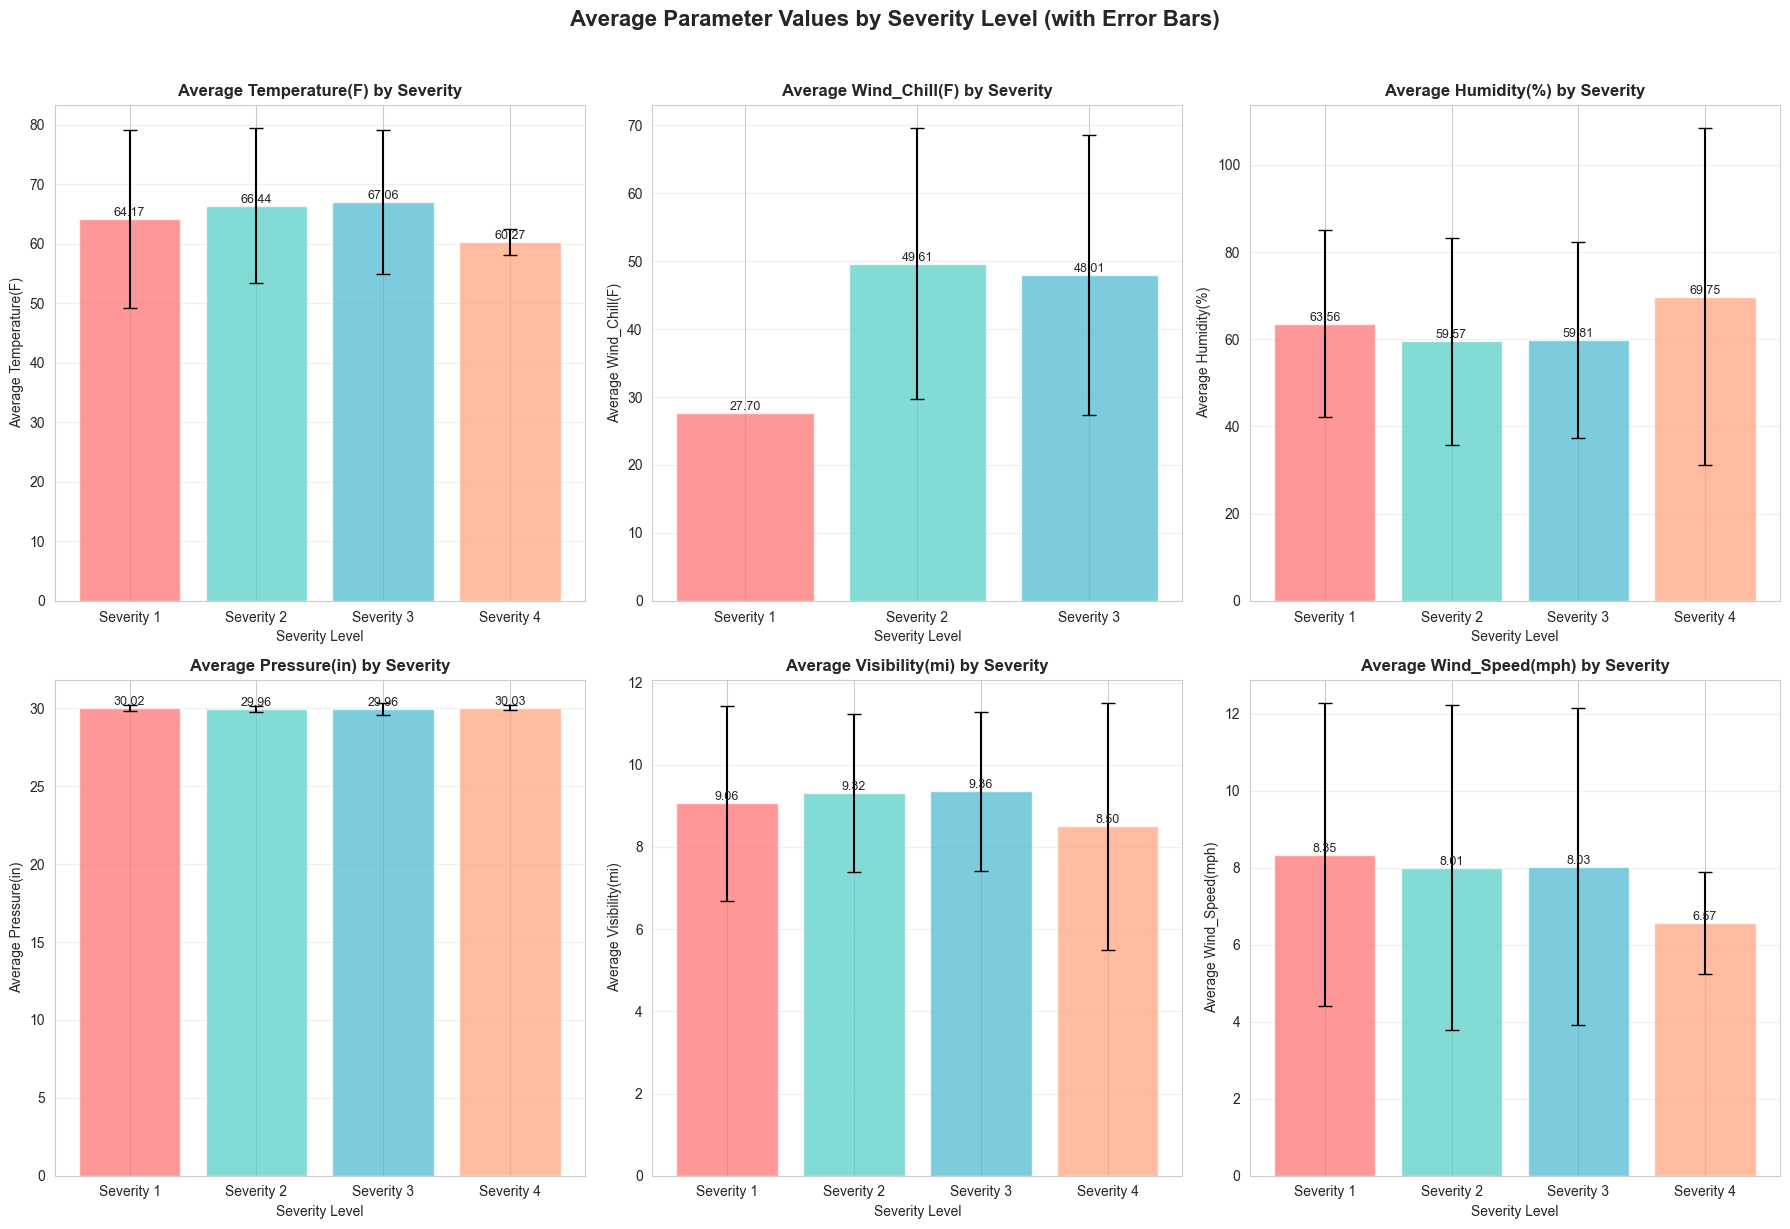

In [11]:
# Bar charts showing average values by severity
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, feature in enumerate(top_numerical):
    severity_means = []
    severity_stds = []
    severity_labels = []
    
    for severity in sorted(df['Severity'].dropna().unique()):
        data = df[df['Severity'] == severity][feature].dropna()
        if len(data) > 0:
            severity_means.append(data.mean())
            severity_stds.append(data.std())
            severity_labels.append(f'Severity {int(severity)}')
    
    x_pos = np.arange(len(severity_labels))
    bars = axes[idx].bar(x_pos, severity_means, yerr=severity_stds, 
                         capsize=5, alpha=0.7, color=colors[:len(severity_labels)])
    axes[idx].set_xlabel('Severity Level')
    axes[idx].set_ylabel(f'Average {feature}')
    axes[idx].set_title(f'Average {feature} by Severity', fontsize=12, fontweight='bold')
    axes[idx].set_xticks(x_pos)
    axes[idx].set_xticklabels(severity_labels)
    axes[idx].grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for bar, mean_val in zip(bars, severity_means):
        height = bar.get_height()
        axes[idx].text(bar.get_x() + bar.get_width()/2., height,
                      f'{mean_val:.2f}', ha='center', va='bottom', fontsize=9)

plt.suptitle('Average Parameter Values by Severity Level (with Error Bars)', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


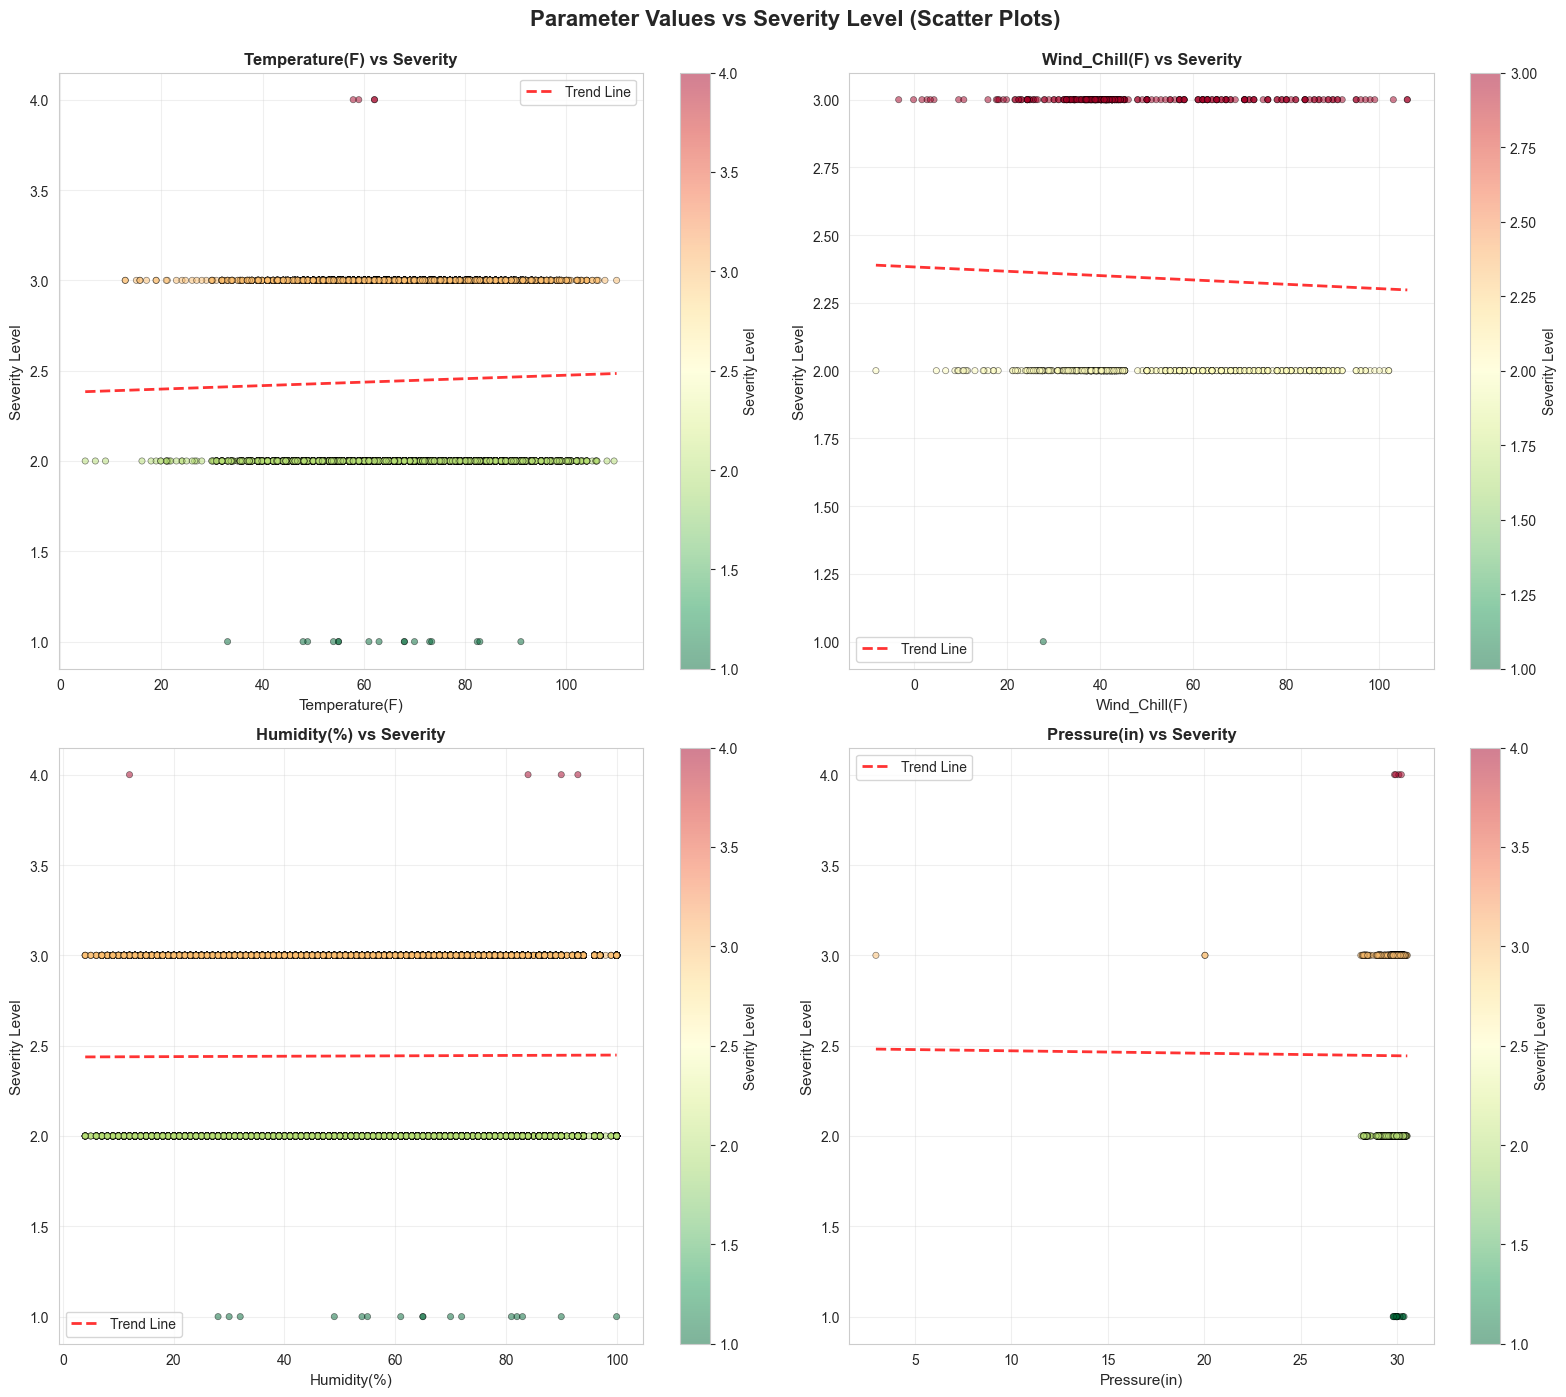

In [12]:
# Scatter plots showing relationship between parameters and severity
# Select top 4 most important numerical features for pairwise comparison
if len(top_numerical) >= 2:
    fig, axes = plt.subplots(2, 2, figsize=(16, 14))
    axes = axes.flatten()
    
    # Create scatter plots for top 4 features
    top_4_features = top_numerical[:4]
    
    for idx, feature in enumerate(top_4_features):
        scatter_data = df[[feature, 'Severity']].dropna()
        
        # Create scatter plot with color coding by severity
        scatter = axes[idx].scatter(scatter_data[feature], scatter_data['Severity'], 
                                   c=scatter_data['Severity'], cmap='RdYlGn_r', 
                                   alpha=0.5, s=20, edgecolors='black', linewidth=0.5)
        
        axes[idx].set_xlabel(feature, fontsize=11)
        axes[idx].set_ylabel('Severity Level', fontsize=11)
        axes[idx].set_title(f'{feature} vs Severity', fontsize=12, fontweight='bold')
        axes[idx].grid(True, alpha=0.3)
        
        # Add trend line
        z = np.polyfit(scatter_data[feature], scatter_data['Severity'], 1)
        p = np.poly1d(z)
        axes[idx].plot(scatter_data[feature].sort_values(), 
                      p(scatter_data[feature].sort_values()), 
                      "r--", alpha=0.8, linewidth=2, label='Trend Line')
        axes[idx].legend()
        
        plt.colorbar(scatter, ax=axes[idx], label='Severity Level')
    
    plt.suptitle('Parameter Values vs Severity Level (Scatter Plots)', 
                 fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()


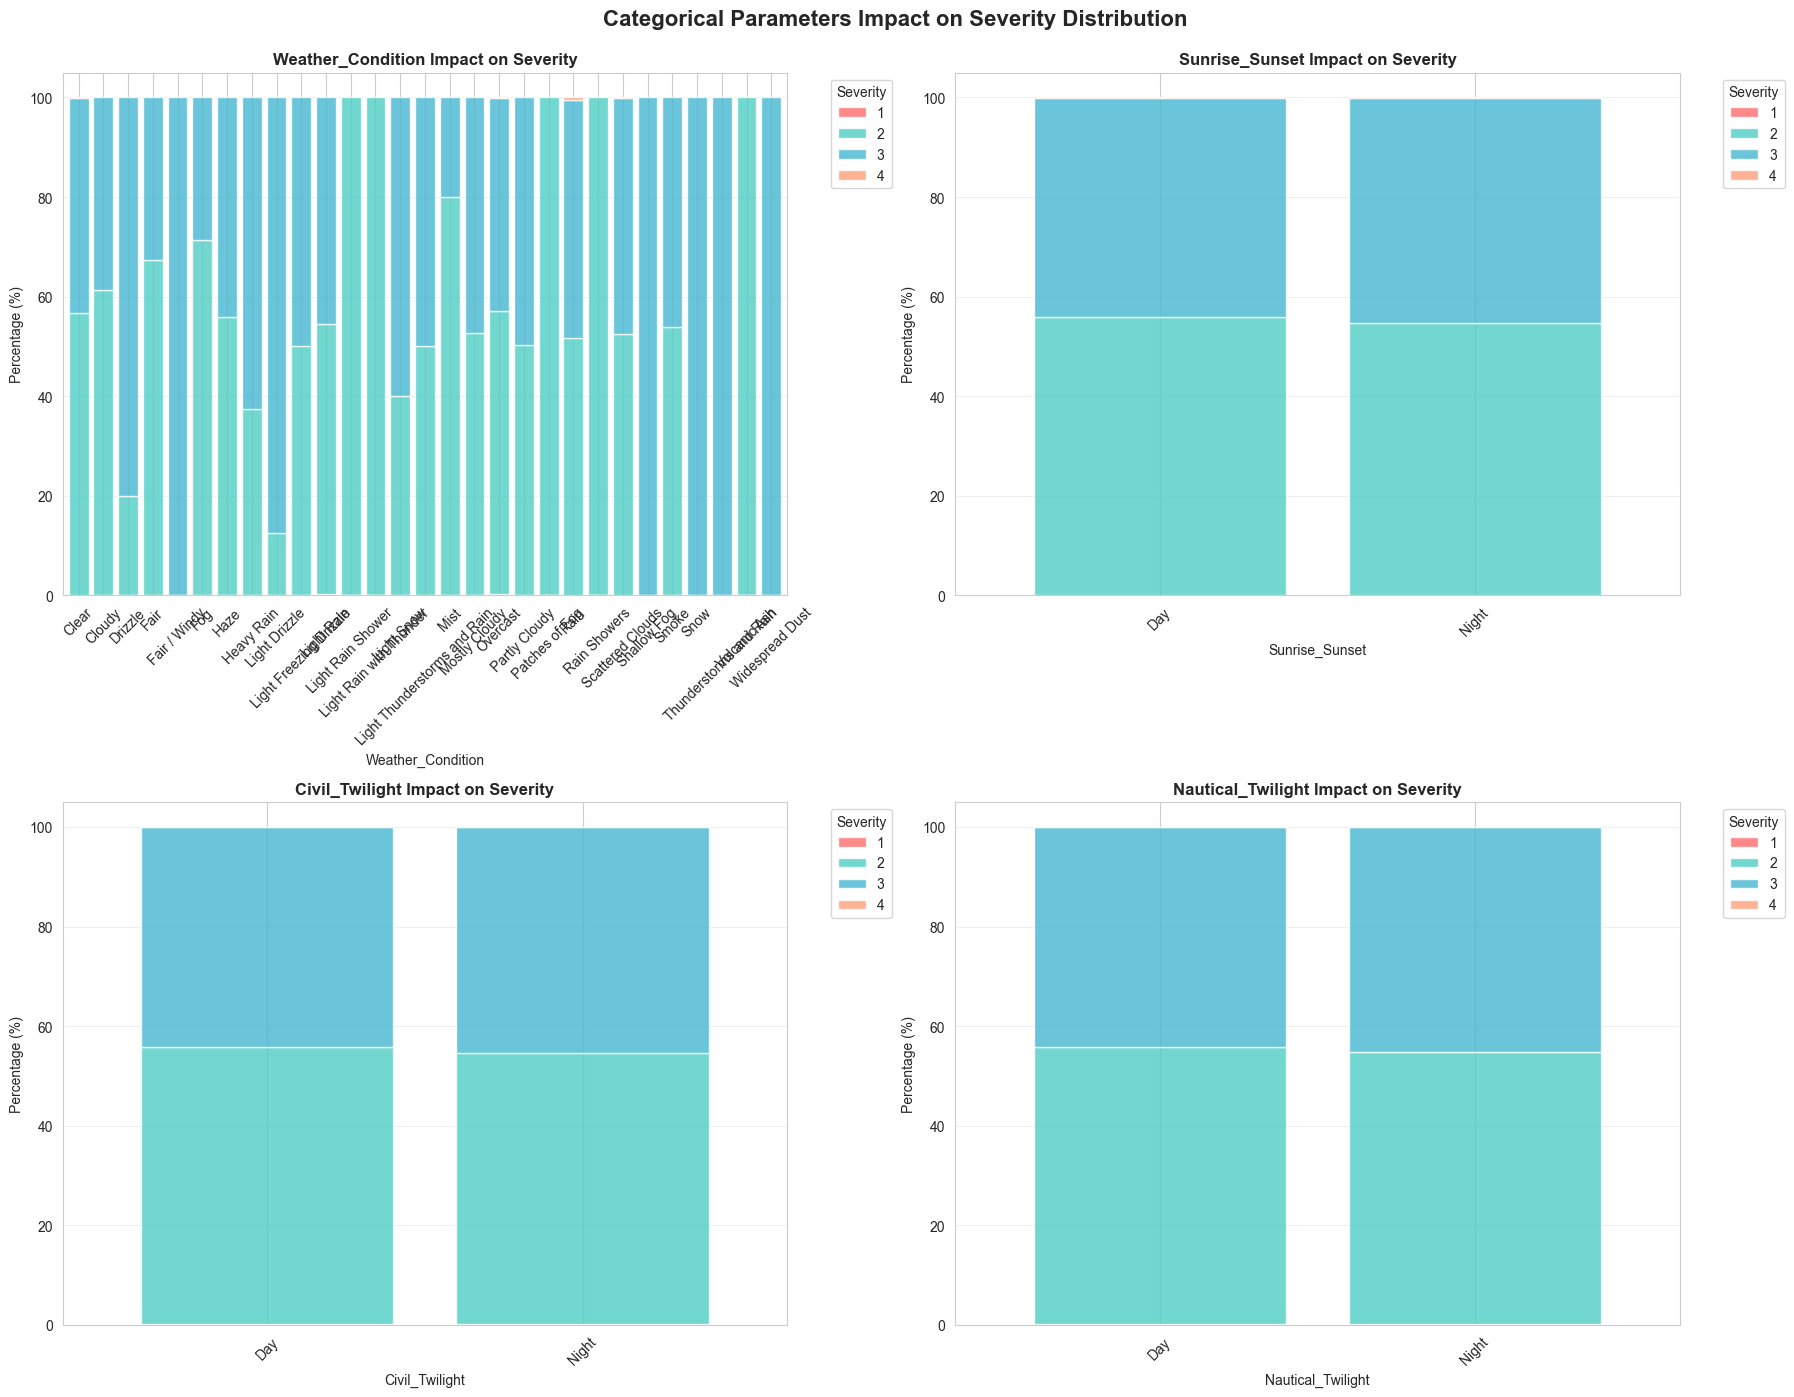

In [13]:
# Categorical features impact on severity
categorical_available = [f for f in categorical_features if f in df.columns]

if len(categorical_available) > 0:
    # Take first 4 categorical features
    top_categorical = categorical_available[:4]
    
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))
    axes = axes.flatten()
    
    for idx, feature in enumerate(top_categorical):
        # Calculate severity distribution for each category
        category_severity = df.groupby([feature, 'Severity']).size().unstack(fill_value=0)
        category_severity_pct = category_severity.div(category_severity.sum(axis=1), axis=0) * 100
        
        # Plot stacked bar chart
        category_severity_pct.plot(kind='bar', stacked=True, ax=axes[idx], 
                                   color=colors[:len(category_severity_pct.columns)], 
                                   alpha=0.8, width=0.8)
        
        axes[idx].set_title(f'{feature} Impact on Severity', fontsize=12, fontweight='bold')
        axes[idx].set_xlabel(feature)
        axes[idx].set_ylabel('Percentage (%)')
        axes[idx].legend(title='Severity', bbox_to_anchor=(1.05, 1), loc='upper left')
        axes[idx].tick_params(axis='x', rotation=45)
        axes[idx].grid(True, alpha=0.3, axis='y')
    
    plt.suptitle('Categorical Parameters Impact on Severity Distribution', 
                 fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()


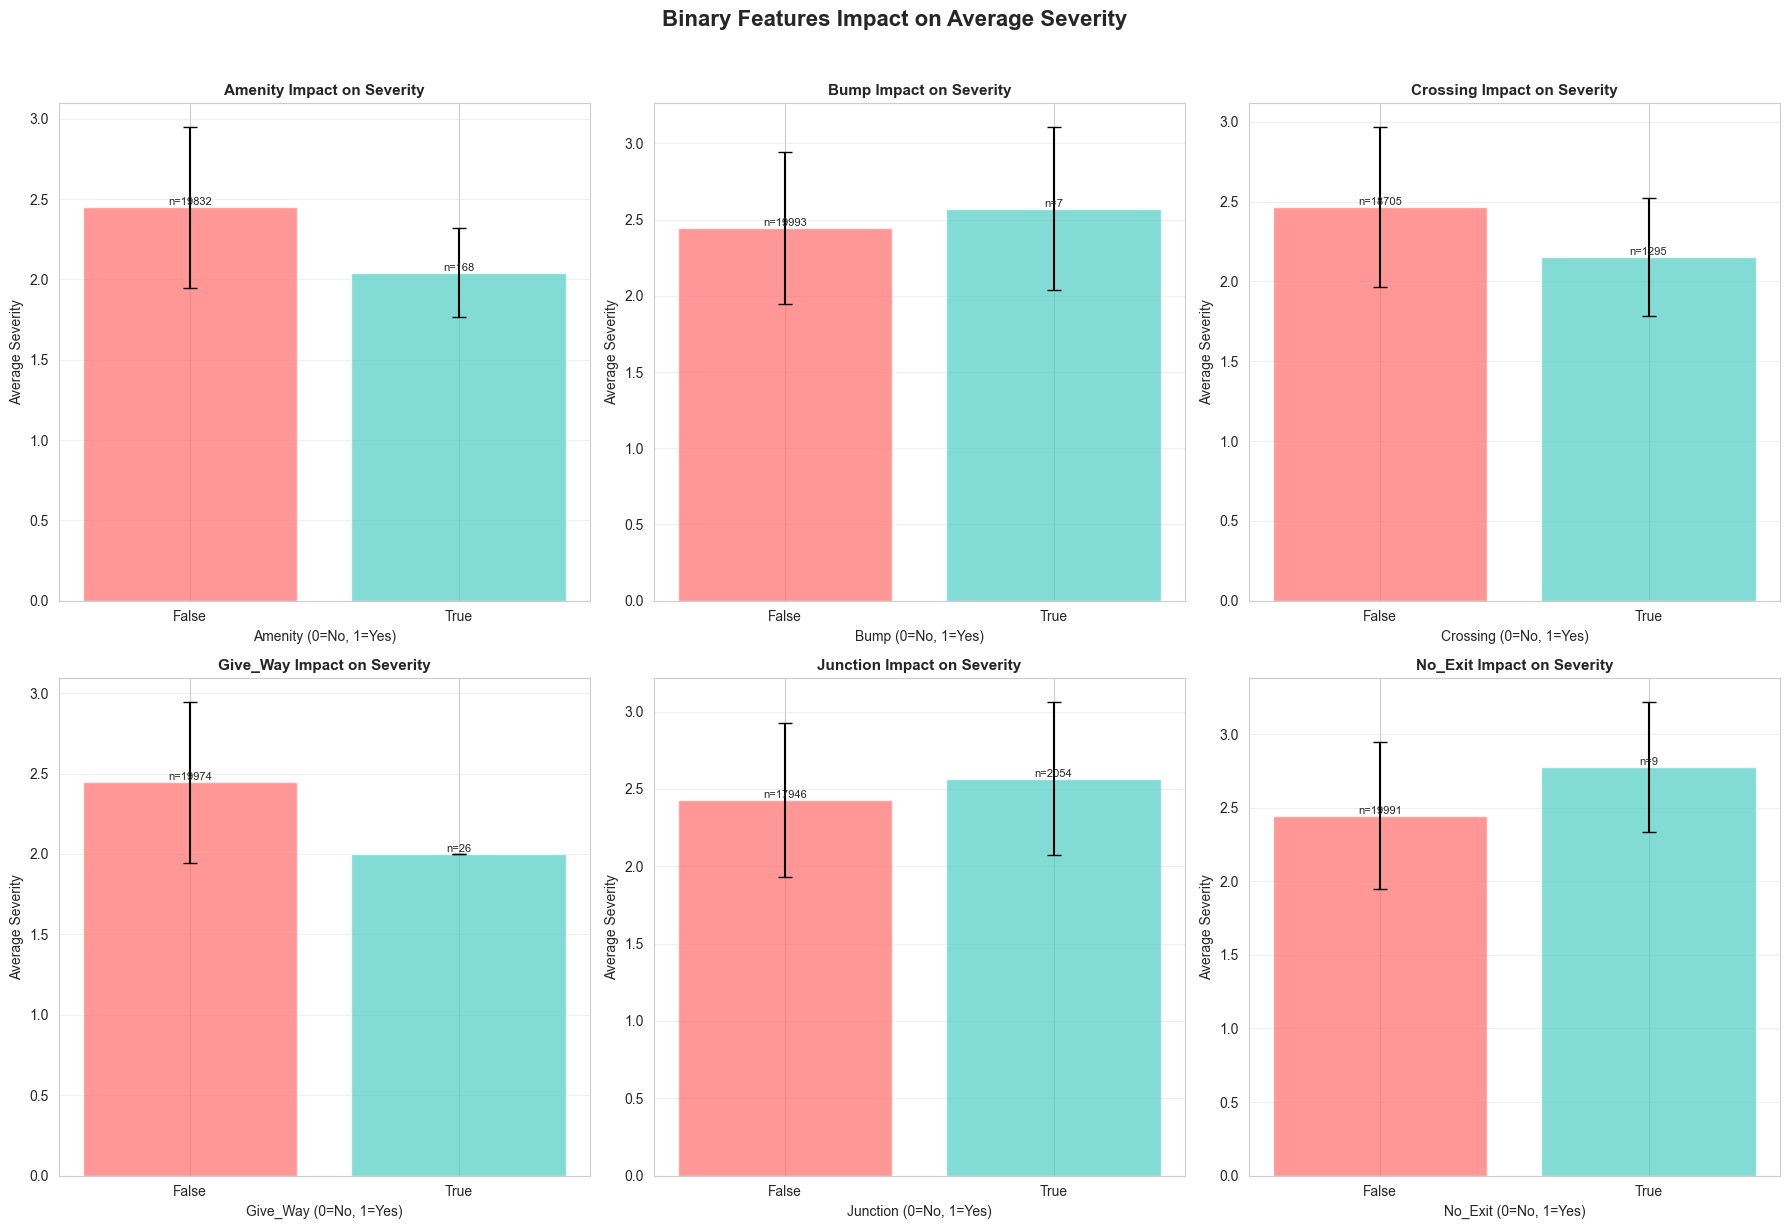

In [14]:
# Binary features impact on severity
binary_available = [f for f in binary_features if f in df.columns]

if len(binary_available) > 0:
    # Take top 6 binary features
    top_binary = binary_available[:6]
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    for idx, feature in enumerate(top_binary):
        # Calculate average severity for each binary value
        binary_severity = df.groupby(feature)['Severity'].agg(['mean', 'std', 'count']).reset_index()
        binary_severity[feature] = binary_severity[feature].astype(str)
        
        # Create bar plot
        bars = axes[idx].bar(binary_severity[feature], binary_severity['mean'], 
                            yerr=binary_severity['std'], capsize=5, 
                            color=colors[:len(binary_severity)], alpha=0.7)
        
        axes[idx].set_title(f'{feature} Impact on Severity', fontsize=11, fontweight='bold')
        axes[idx].set_xlabel(f'{feature} (0=No, 1=Yes)')
        axes[idx].set_ylabel('Average Severity')
        axes[idx].grid(True, alpha=0.3, axis='y')
        
        # Add count labels
        for bar, count in zip(bars, binary_severity['count']):
            height = bar.get_height()
            axes[idx].text(bar.get_x() + bar.get_width()/2., height,
                          f'n={count}', ha='center', va='bottom', fontsize=8)
    
    plt.suptitle('Binary Features Impact on Average Severity', 
                 fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()


In [15]:
# Statistical summary: How parameters differ across severity levels
print("=" * 80)
print("STATISTICAL SUMMARY: Parameter Differences Across Severity Levels")
print("=" * 80)

for feature in top_numerical[:5]:  # Top 5 features
    print(f"\n{feature}:")
    print("-" * 60)
    severity_stats = df.groupby('Severity')[feature].agg(['mean', 'median', 'std', 'min', 'max'])
    print(severity_stats.round(2))
    
    # Calculate difference between highest and lowest severity
    if len(severity_stats) > 1:
        mean_diff = severity_stats['mean'].max() - severity_stats['mean'].min()
        pct_diff = (mean_diff / severity_stats['mean'].min()) * 100 if severity_stats['mean'].min() != 0 else 0
        print(f"\n  Mean difference (max-min): {mean_diff:.2f} ({pct_diff:.1f}% change)")

print("\n" + "=" * 80)


STATISTICAL SUMMARY: Parameter Differences Across Severity Levels

Temperature(F):
------------------------------------------------------------
           mean  median    std   min    max
Severity                                   
1         64.17   65.50  14.99  33.1   91.0
2         66.44   66.00  13.01   5.0  109.4
3         67.06   66.90  12.14  12.9  109.9
4         60.28   60.55   2.15  57.9   62.1

  Mean difference (max-min): 6.79 (11.3% change)

Wind_Chill(F):
------------------------------------------------------------
           mean  median    std   min    max
Severity                                   
1         27.70    27.7    NaN  27.7   27.7
2         49.61    42.5  19.97  -8.3  102.0
3         48.01    41.7  20.63  -3.4  106.0
4           NaN     NaN    NaN   NaN    NaN

  Mean difference (max-min): 21.91 (79.1% change)

Humidity(%):
------------------------------------------------------------
           mean  median    std   min    max
Severity                       

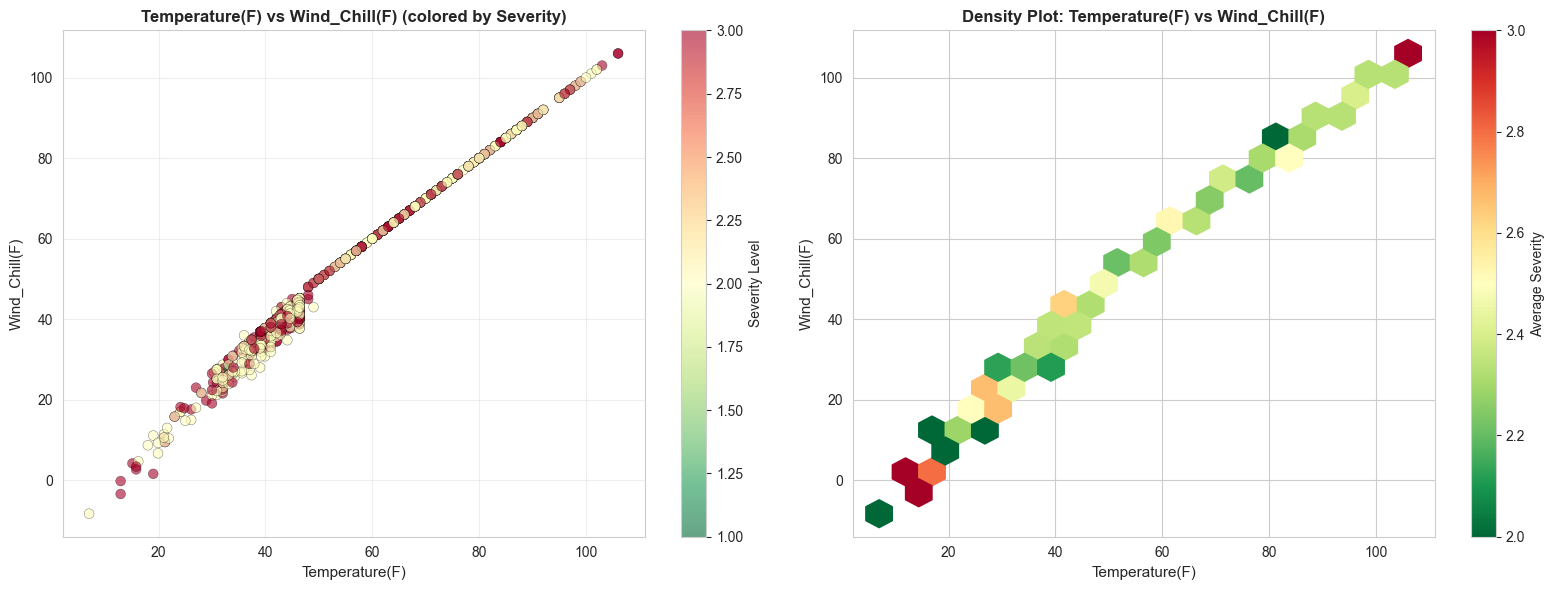

In [16]:
# Pairwise comparison: Show how top 2 parameters interact with severity
if len(top_numerical) >= 2:
    top_2_features = top_numerical[:2]
    
    fig = plt.figure(figsize=(16, 6))
    
    # 3D-like visualization using scatter with size/color
    ax1 = fig.add_subplot(121)
    scatter_data = df[top_2_features + ['Severity']].dropna()
    
    scatter = ax1.scatter(scatter_data[top_2_features[0]], 
                         scatter_data[top_2_features[1]], 
                         c=scatter_data['Severity'], 
                         s=50, alpha=0.6, cmap='RdYlGn_r', 
                         edgecolors='black', linewidth=0.3)
    
    ax1.set_xlabel(top_2_features[0], fontsize=11)
    ax1.set_ylabel(top_2_features[1], fontsize=11)
    ax1.set_title(f'{top_2_features[0]} vs {top_2_features[1]} (colored by Severity)', 
                 fontsize=12, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=ax1, label='Severity Level')
    
    # Hexbin plot for density
    ax2 = fig.add_subplot(122)
    hb = ax2.hexbin(scatter_data[top_2_features[0]], 
                   scatter_data[top_2_features[1]], 
                   C=scatter_data['Severity'], 
                   gridsize=20, cmap='RdYlGn_r', reduce_C_function=np.mean)
    
    ax2.set_xlabel(top_2_features[0], fontsize=11)
    ax2.set_ylabel(top_2_features[1], fontsize=11)
    ax2.set_title(f'Density Plot: {top_2_features[0]} vs {top_2_features[1]}', 
                 fontsize=12, fontweight='bold')
    plt.colorbar(hb, ax=ax2, label='Average Severity')
    
    plt.tight_layout()
    plt.show()


### Key Insights from Parameter-Severity Visualizations

The graphs above show:
- **Box/Violin Plots**: Distribution shapes and outliers for each severity level
- **Heatmaps**: Quick comparison of average values across severity levels
- **Bar Charts**: Clear average values with error bars showing variability
- **Scatter Plots**: Individual data points and trends
- **Categorical Analysis**: How categorical features affect severity distribution
- **Binary Features**: Impact of presence/absence of road features on severity

These visualizations help identify which parameters have the strongest relationship with accident severity.


## 4. Random Forest Feature Importance


Training set: 16000 samples
Test set: 4000 samples

Random Forest Feature Importance:
Humidity(%)                   :  0.2092
Pressure(in)                  :  0.2089
Temperature(F)                :  0.2045
Wind_Speed(mph)               :  0.1274
Weather_Condition             :  0.0494
Visibility(mi)                :  0.0398
Traffic_Signal                :  0.0377
Distance(mi)                  :  0.0162
Stop                          :  0.0156
Crossing                      :  0.0147
Junction                      :  0.0108
Wind_Chill(F)                 :  0.0105
Precipitation(in)             :  0.0092
Sunrise_Sunset                :  0.0091
Astronomical_Twilight         :  0.0086
Nautical_Twilight             :  0.0069
Civil_Twilight                :  0.0068
Station                       :  0.0062
Railway                       :  0.0050
Amenity                       :  0.0027
No_Exit                       :  0.0004
Give_Way                      :  0.0002
Traffic_Calming               :  0

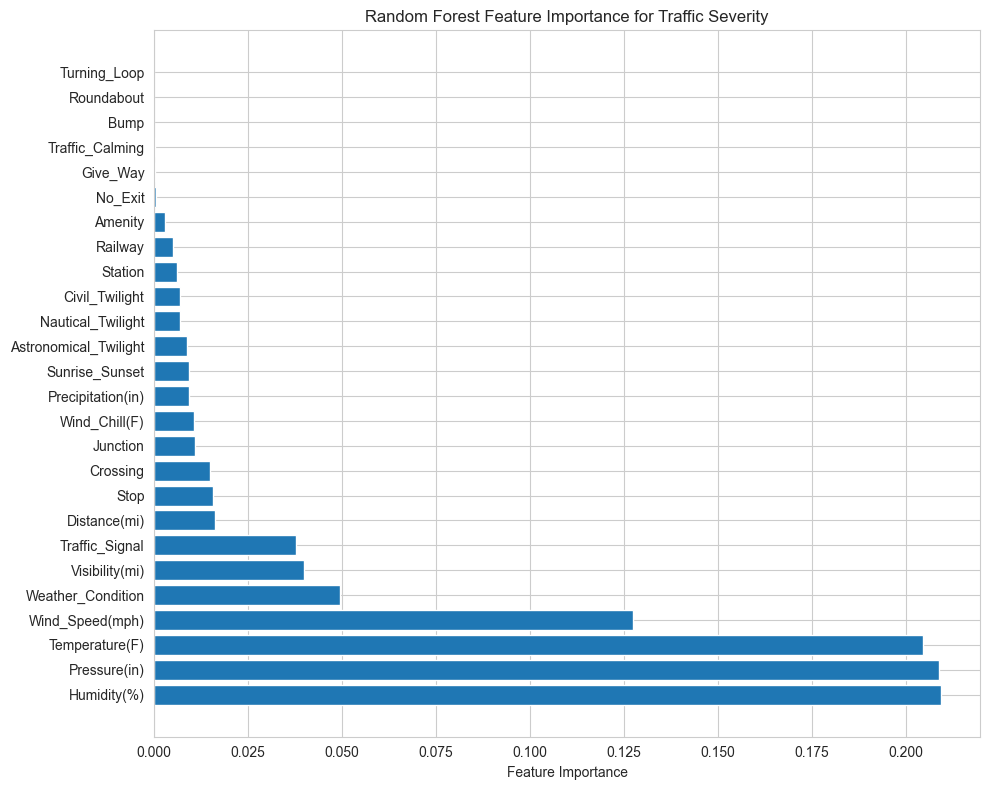

In [17]:
# Prepare data for modeling
X = feature_df.drop('Severity', axis=1)
y = feature_df['Severity']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=38, stratify=y
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=38, n_jobs=-1)
rf_model.fit(X_train, y_train)

# Get feature importances
feature_importance_rf = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nRandom Forest Feature Importance:")
print("=" * 60)
for idx, row in feature_importance_rf.iterrows():
    print(f"{row['feature']:30s}: {row['importance']:7.4f}")

# Visualize
plt.figure(figsize=(10, 8))
plt.barh(range(len(feature_importance_rf)), feature_importance_rf['importance'].values)
plt.yticks(range(len(feature_importance_rf)), feature_importance_rf['feature'].values)
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importance for Traffic Severity')
plt.tight_layout()
plt.show()


In [18]:
# Evaluate model
y_pred_rf = rf_model.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"\nRandom Forest Accuracy: {accuracy_rf:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))



Random Forest Accuracy: 0.6002

Classification Report:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         3
           2       0.63      0.66      0.65      2215
           3       0.55      0.53      0.54      1781
           4       0.00      0.00      0.00         1

    accuracy                           0.60      4000
   macro avg       0.30      0.30      0.30      4000
weighted avg       0.60      0.60      0.60      4000



## 5. Gradient Boosting Feature Importance


Gradient Boosting Feature Importance:
Traffic_Signal                :  0.3103
Stop                          :  0.1280
Temperature(F)                :  0.0999
Pressure(in)                  :  0.0864
Distance(mi)                  :  0.0859
Humidity(%)                   :  0.0719
Crossing                      :  0.0437
Railway                       :  0.0265
Weather_Condition             :  0.0264
Junction                      :  0.0236
Wind_Speed(mph)               :  0.0229
Wind_Chill(F)                 :  0.0172
Station                       :  0.0125
Amenity                       :  0.0113
Visibility(mi)                :  0.0085
Civil_Twilight                :  0.0070
Precipitation(in)             :  0.0053
Sunrise_Sunset                :  0.0051
Astronomical_Twilight         :  0.0034
Nautical_Twilight             :  0.0021
No_Exit                       :  0.0017
Give_Way                      :  0.0003
Bump                          :  0.0000
Roundabout                    :  0.0000
Tr

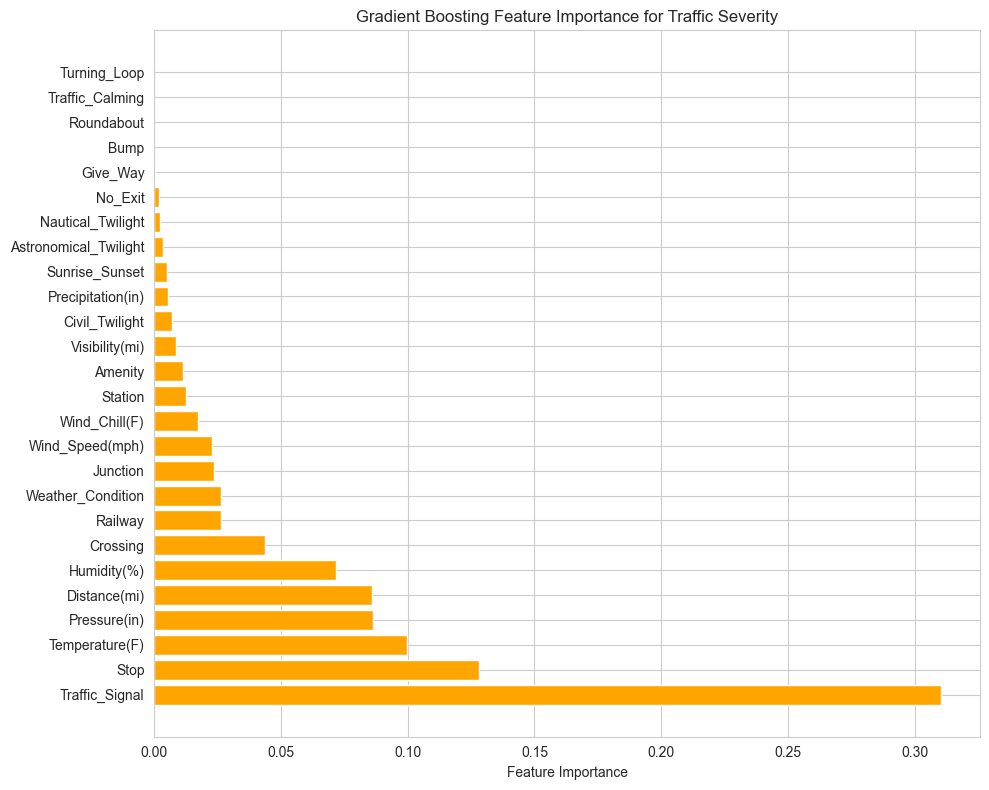

In [19]:
# Train Gradient Boosting
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=38)
gb_model.fit(X_train, y_train)

# Get feature importances
feature_importance_gb = pd.DataFrame({
    'feature': X.columns,
    'importance': gb_model.feature_importances_
}).sort_values('importance', ascending=False)

print("Gradient Boosting Feature Importance:")
print("=" * 60)
for idx, row in feature_importance_gb.iterrows():
    print(f"{row['feature']:30s}: {row['importance']:7.4f}")

# Visualize
plt.figure(figsize=(10, 8))
plt.barh(range(len(feature_importance_gb)), feature_importance_gb['importance'].values, color='orange')
plt.yticks(range(len(feature_importance_gb)), feature_importance_gb['feature'].values)
plt.xlabel('Feature Importance')
plt.title('Gradient Boosting Feature Importance for Traffic Severity')
plt.tight_layout()
plt.show()


In [20]:
# Evaluate model
y_pred_gb = gb_model.predict(X_test)
accuracy_gb = accuracy_score(y_test, y_pred_gb)
print(f"\nGradient Boosting Accuracy: {accuracy_gb:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_gb))



Gradient Boosting Accuracy: 0.6020

Classification Report:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         3
           2       0.65      0.61      0.63      2215
           3       0.55      0.60      0.57      1781
           4       0.00      0.00      0.00         1

    accuracy                           0.60      4000
   macro avg       0.30      0.30      0.30      4000
weighted avg       0.61      0.60      0.60      4000



## 6. Logistic Regression Coefficients


Logistic Regression Feature Importance (Average Absolute Coefficients):
Traffic_Signal                :  0.3802
Crossing                      :  0.2709
Stop                          :  0.2355
Junction                      :  0.1981
Weather_Condition             :  0.1627
Pressure(in)                  :  0.1584
Amenity                       :  0.1541
Temperature(F)                :  0.1499
Give_Way                      :  0.1436
Railway                       :  0.1209
Wind_Chill(F)                 :  0.1169
Humidity(%)                   :  0.1061
Civil_Twilight                :  0.0901
Traffic_Calming               :  0.0899
Visibility(mi)                :  0.0887
Wind_Speed(mph)               :  0.0845
Astronomical_Twilight         :  0.0713
Precipitation(in)             :  0.0654
Station                       :  0.0626
Bump                          :  0.0565
Sunrise_Sunset                :  0.0507
No_Exit                       :  0.0408
Nautical_Twilight             :  0.0405
Roundabo

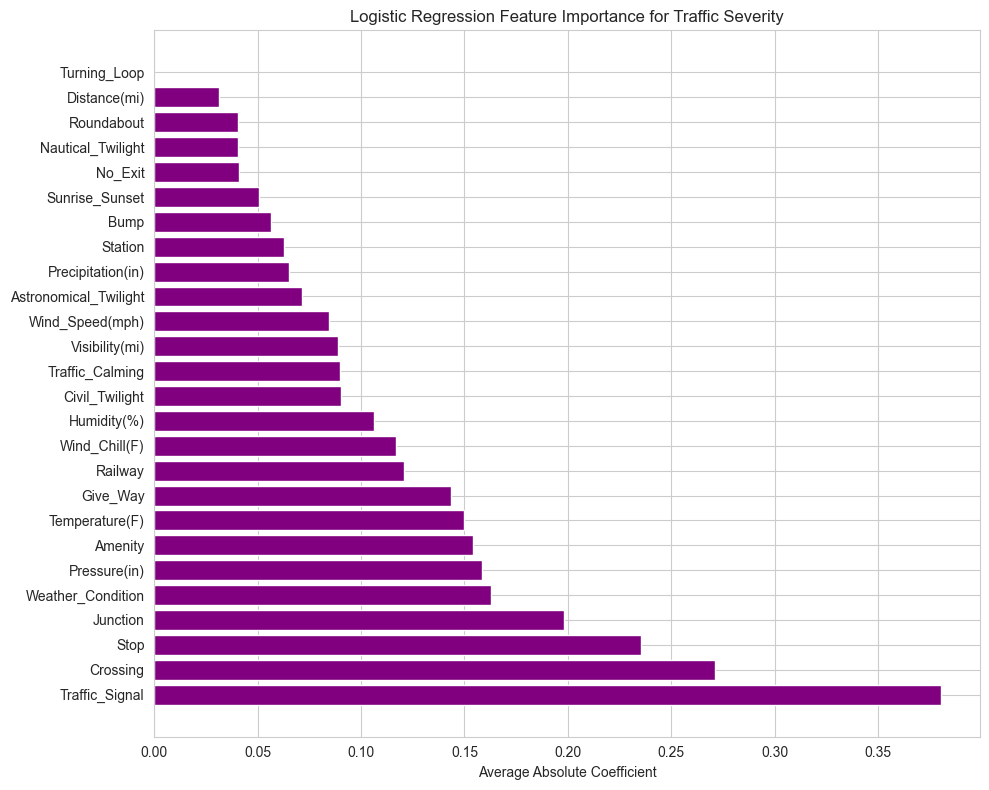

In [21]:
# Scale features for logistic regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Logistic Regression (for multi-class, we'll use one-vs-rest)
lr_model = LogisticRegression(max_iter=1000, random_state=38, multi_class='ovr')
lr_model.fit(X_train_scaled, y_train)

# Get average absolute coefficients across all classes
coef_abs = np.abs(lr_model.coef_).mean(axis=0)
feature_importance_lr = pd.DataFrame({
    'feature': X.columns,
    'coefficient': coef_abs
}).sort_values('coefficient', ascending=False)

print("Logistic Regression Feature Importance (Average Absolute Coefficients):")
print("=" * 60)
for idx, row in feature_importance_lr.iterrows():
    print(f"{row['feature']:30s}: {row['coefficient']:7.4f}")

# Visualize
plt.figure(figsize=(10, 8))
plt.barh(range(len(feature_importance_lr)), feature_importance_lr['coefficient'].values, color='purple')
plt.yticks(range(len(feature_importance_lr)), feature_importance_lr['feature'].values)
plt.xlabel('Average Absolute Coefficient')
plt.title('Logistic Regression Feature Importance for Traffic Severity')
plt.tight_layout()
plt.show()


In [22]:
# Evaluate model
y_pred_lr = lr_model.predict(X_test_scaled)
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print(f"\nLogistic Regression Accuracy: {accuracy_lr:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr))



Logistic Regression Accuracy: 0.5910

Classification Report:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         3
           2       0.61      0.70      0.66      2215
           3       0.55      0.45      0.50      1781
           4       0.00      0.00      0.00         1

    accuracy                           0.59      4000
   macro avg       0.29      0.29      0.29      4000
weighted avg       0.59      0.59      0.58      4000



## 7. Combined Feature Importance Analysis


In [23]:
# Normalize all importance scores to 0-1 range for comparison
def normalize_scores(scores):
    min_val = scores.min()
    max_val = scores.max()
    if max_val - min_val == 0:
        return scores
    return (scores - min_val) / (max_val - min_val)

# Combine all importance metrics
combined_importance = pd.DataFrame({
    'feature': X.columns,
    'correlation': correlations.abs().values,
    'rf_importance': feature_importance_rf['importance'].values,
    'gb_importance': feature_importance_gb['importance'].values,
    'lr_importance': feature_importance_lr['coefficient'].values
})

# Normalize each column
combined_importance['correlation_norm'] = normalize_scores(combined_importance['correlation'])
combined_importance['rf_importance_norm'] = normalize_scores(combined_importance['rf_importance'])
combined_importance['gb_importance_norm'] = normalize_scores(combined_importance['gb_importance'])
combined_importance['lr_importance_norm'] = normalize_scores(combined_importance['lr_importance'])

# Calculate average normalized importance
combined_importance['avg_importance'] = (
    combined_importance['correlation_norm'] + 
    combined_importance['rf_importance_norm'] + 
    combined_importance['gb_importance_norm'] + 
    combined_importance['lr_importance_norm']
) / 4

combined_importance = combined_importance.sort_values('avg_importance', ascending=False)

print("Combined Feature Importance Ranking:")
print("=" * 80)
print(f"{'Feature':<30} {'Avg Importance':<15} {'Correlation':<12} {'RF':<12} {'GB':<12} {'LR':<12}")
print("=" * 80)
for idx, row in combined_importance.iterrows():
    print(f"{row['feature']:<30} {row['avg_importance']:<15.4f} {row['correlation_norm']:<12.4f} "
          f"{row['rf_importance_norm']:<12.4f} {row['gb_importance_norm']:<12.4f} {row['lr_importance_norm']:<12.4f}")


Combined Feature Importance Ranking:
Feature                        Avg Importance  Correlation  RF           GB           LR          
Temperature(F)                 0.8496          0.3982       1.0000       1.0000       1.0000      
Wind_Chill(F)                  0.5705          0.1587       0.9984       0.4124       0.7124      
Humidity(%)                    0.5078          0.1127       0.9773       0.3218       0.6194      
Pressure(in)                   0.3684          0.0653       0.6090       0.2783       0.5211      
Traffic_Signal                 0.2706          1.0000       0.0001       0.0000       0.0823      
Visibility(mi)                 0.2491          0.0554       0.2361       0.2770       0.4278      
Wind_Speed(mph)                0.2225          0.0512       0.1904       0.2316       0.4167      
Traffic_Calming                0.2145          0.7516       0.0003       0.0000       0.1061      
Precipitation(in)              0.1942          0.0504       0.1802      

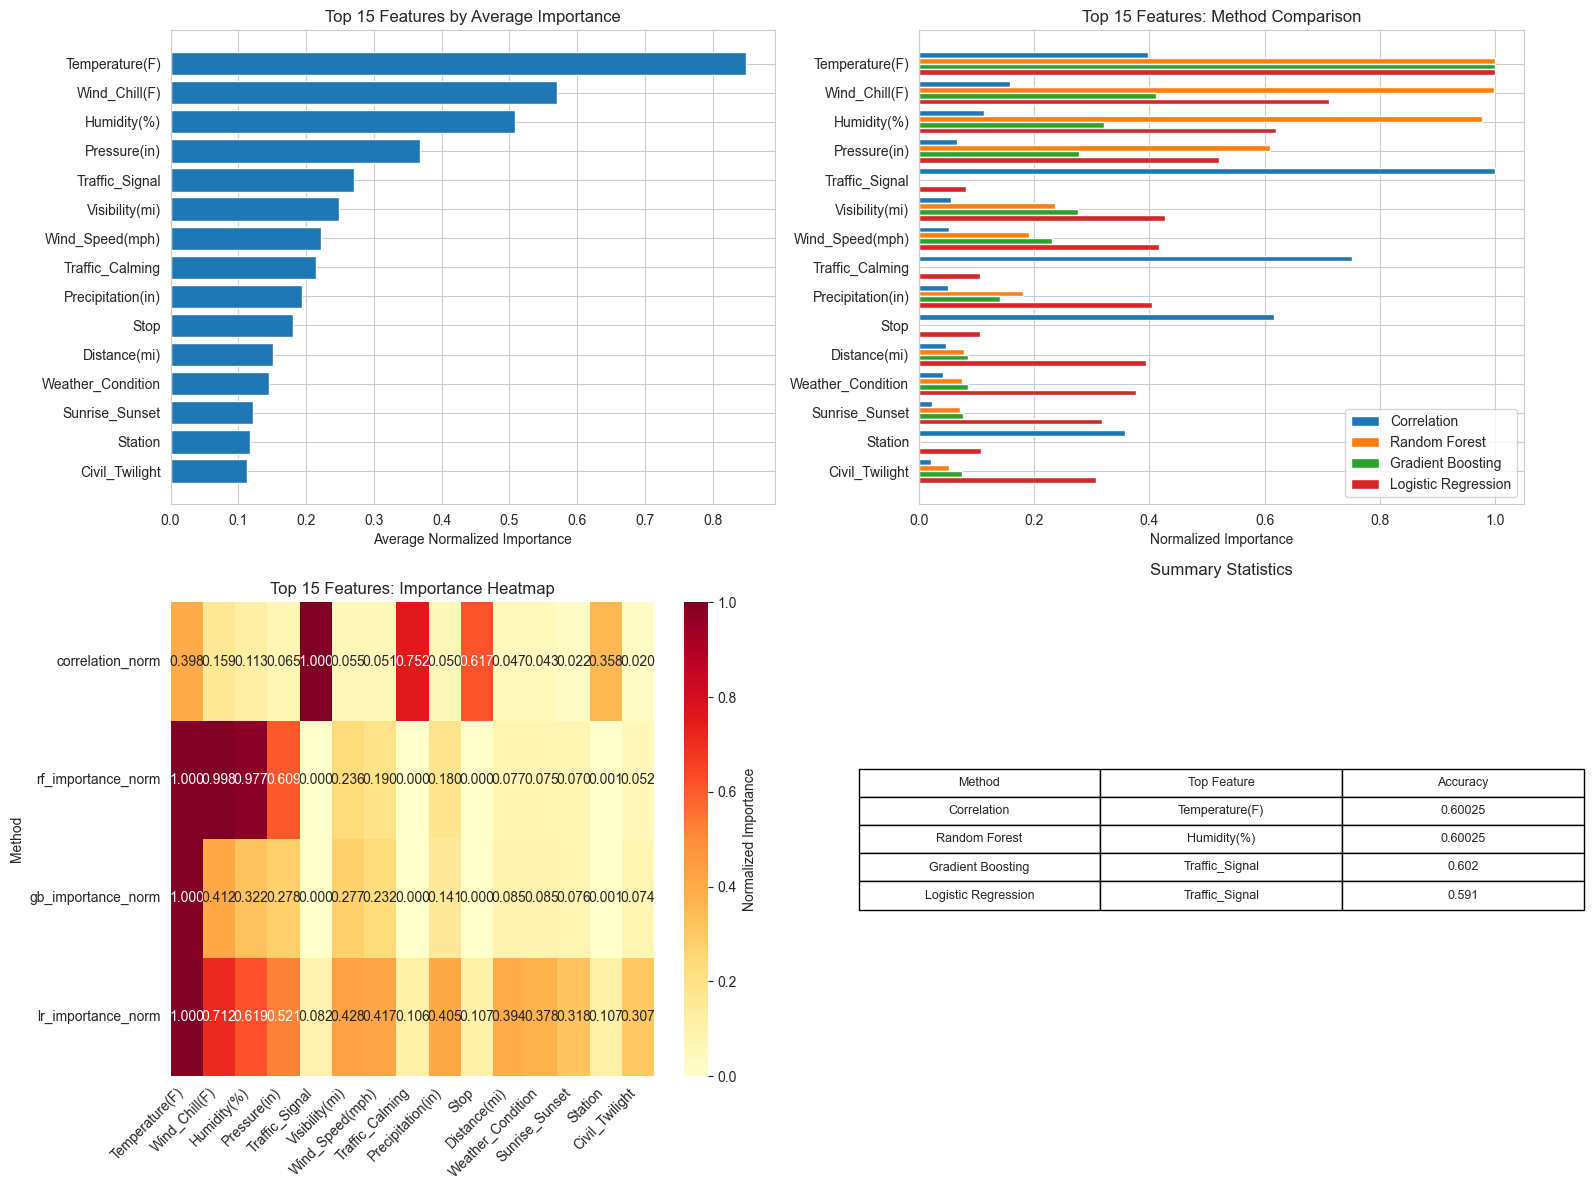

In [24]:
# Visualize combined importance
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Top 15 features by average importance
top_n = 15
top_features = combined_importance.head(top_n)

# Plot 1: Average Importance
axes[0, 0].barh(range(len(top_features)), top_features['avg_importance'].values)
axes[0, 0].set_yticks(range(len(top_features)))
axes[0, 0].set_yticklabels(top_features['feature'].values)
axes[0, 0].set_xlabel('Average Normalized Importance')
axes[0, 0].set_title(f'Top {top_n} Features by Average Importance')
axes[0, 0].invert_yaxis()

# Plot 2: Comparison of all methods
x_pos = np.arange(len(top_features))
width = 0.2
axes[0, 1].barh(x_pos - 1.5*width, top_features['correlation_norm'].values, width, label='Correlation')
axes[0, 1].barh(x_pos - 0.5*width, top_features['rf_importance_norm'].values, width, label='Random Forest')
axes[0, 1].barh(x_pos + 0.5*width, top_features['gb_importance_norm'].values, width, label='Gradient Boosting')
axes[0, 1].barh(x_pos + 1.5*width, top_features['lr_importance_norm'].values, width, label='Logistic Regression')
axes[0, 1].set_yticks(x_pos)
axes[0, 1].set_yticklabels(top_features['feature'].values)
axes[0, 1].set_xlabel('Normalized Importance')
axes[0, 1].set_title(f'Top {top_n} Features: Method Comparison')
axes[0, 1].legend()
axes[0, 1].invert_yaxis()

# Plot 3: Heatmap of importance scores
importance_matrix = top_features[['correlation_norm', 'rf_importance_norm', 'gb_importance_norm', 'lr_importance_norm']].T
importance_matrix.columns = top_features['feature'].values
sns.heatmap(importance_matrix, annot=True, fmt='.3f', cmap='YlOrRd', ax=axes[1, 0], cbar_kws={'label': 'Normalized Importance'})
axes[1, 0].set_title(f'Top {top_n} Features: Importance Heatmap')
axes[1, 0].set_ylabel('Method')
axes[1, 0].set_xticklabels(axes[1, 0].get_xticklabels(), rotation=45, ha='right')

# Plot 4: Summary statistics
summary_stats = {
    'Method': ['Correlation', 'Random Forest', 'Gradient Boosting', 'Logistic Regression'],
    'Top Feature': [
        combined_importance.iloc[0]['feature'],
        feature_importance_rf.iloc[0]['feature'],
        feature_importance_gb.iloc[0]['feature'],
        feature_importance_lr.iloc[0]['feature']
    ],
    'Accuracy': [accuracy_rf, accuracy_rf, accuracy_gb, accuracy_lr]
}
summary_df = pd.DataFrame(summary_stats)
axes[1, 1].axis('tight')
axes[1, 1].axis('off')
table = axes[1, 1].table(cellText=summary_df.values, colLabels=summary_df.columns, 
                         cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1.2, 1.5)
axes[1, 1].set_title('Summary Statistics', pad=20)

plt.tight_layout()
plt.show()


## 8. Top Contributing Parameters Summary


In [25]:
# Display top contributing parameters
print("=" * 80)
print("TOP PARAMETERS CONTRIBUTING TO TRAFFIC SEVERITY")
print("=" * 80)
print(f"\nTop 10 Most Important Parameters (by average importance):\n")
for i, (idx, row) in enumerate(combined_importance.head(10).iterrows(), 1):
    print(f"{i:2d}. {row['feature']:30s} (Avg Importance: {row['avg_importance']:.4f})")
    
print("\n" + "=" * 80)
print("KEY INSIGHTS:")
print("=" * 80)
print(f"1. Most Important Feature: {combined_importance.iloc[0]['feature']}")
print(f"2. Random Forest Top Feature: {feature_importance_rf.iloc[0]['feature']}")
print(f"3. Gradient Boosting Top Feature: {feature_importance_gb.iloc[0]['feature']}")
print(f"4. Highest Correlation: {correlations.abs().idxmax()} ({correlations.abs().max():.4f})")
print(f"\n5. Model Accuracies:")
print(f"   - Random Forest: {accuracy_rf:.4f}")
print(f"   - Gradient Boosting: {accuracy_gb:.4f}")
print(f"   - Logistic Regression: {accuracy_lr:.4f}")
print("=" * 80)


TOP PARAMETERS CONTRIBUTING TO TRAFFIC SEVERITY

Top 10 Most Important Parameters (by average importance):

 1. Temperature(F)                 (Avg Importance: 0.8496)
 2. Wind_Chill(F)                  (Avg Importance: 0.5705)
 3. Humidity(%)                    (Avg Importance: 0.5078)
 4. Pressure(in)                   (Avg Importance: 0.3684)
 5. Traffic_Signal                 (Avg Importance: 0.2706)
 6. Visibility(mi)                 (Avg Importance: 0.2491)
 7. Wind_Speed(mph)                (Avg Importance: 0.2225)
 8. Traffic_Calming                (Avg Importance: 0.2145)
 9. Precipitation(in)              (Avg Importance: 0.1942)
10. Stop                           (Avg Importance: 0.1809)

KEY INSIGHTS:
1. Most Important Feature: Temperature(F)
2. Random Forest Top Feature: Humidity(%)
3. Gradient Boosting Top Feature: Traffic_Signal
4. Highest Correlation: Traffic_Signal (0.2063)

5. Model Accuracies:
   - Random Forest: 0.6002
   - Gradient Boosting: 0.6020
   - Logistic Re

## 9. Detailed Analysis of Top Features


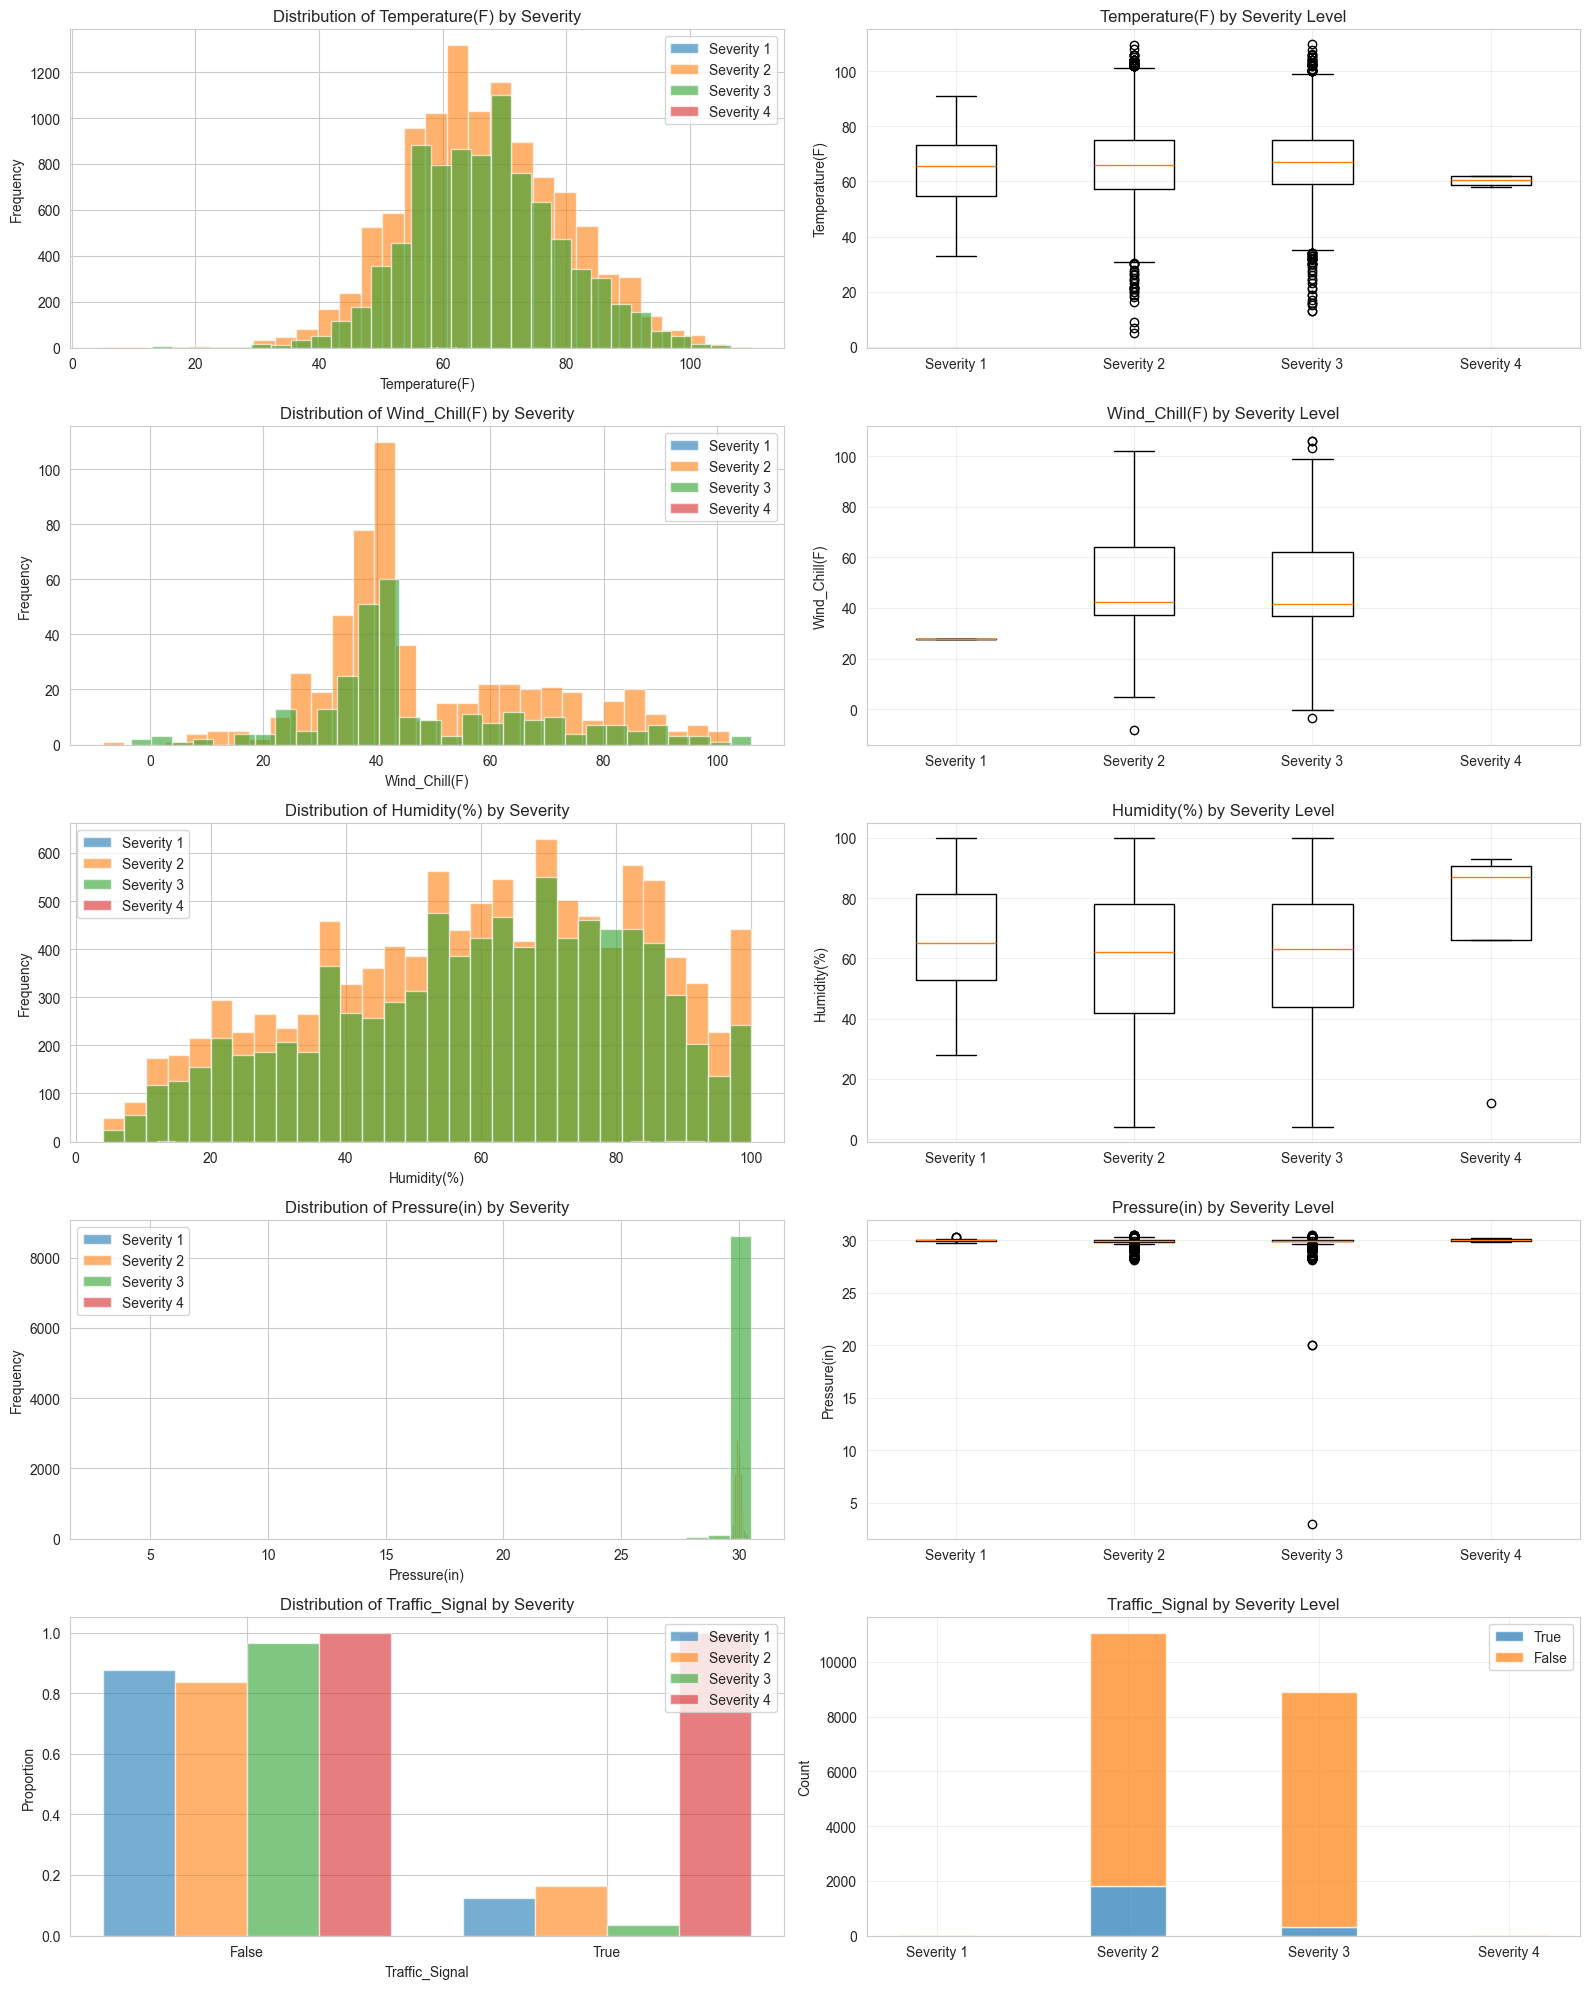

In [27]:
# Analyze top 5 features in detail
top_5_features = combined_importance.head(5)['feature'].tolist()

fig, axes = plt.subplots(len(top_5_features), 2, figsize=(16, 4*len(top_5_features)))

for idx, feature in enumerate(top_5_features):
    # Check if feature is binary/boolean
    unique_vals = df[feature].dropna().unique()
    is_binary = len(unique_vals) <= 2 or df[feature].dtype == 'bool'
    
    # Distribution by severity
    if is_binary:
        # For binary features, use bar plots instead of histograms
        x_pos = np.arange(len(unique_vals))
        width = 0.2
        severity_levels = sorted(df['Severity'].unique())
        
        for i, severity in enumerate(severity_levels):
            severity_data = df[df['Severity'] == severity][feature].value_counts(normalize=True, sort=False)
            axes[idx, 0].bar(x_pos + i*width, severity_data.values, width, 
                           alpha=0.6, label=f'Severity {severity}')
        
        axes[idx, 0].set_xticks(x_pos + width*1.5)
        axes[idx, 0].set_xticklabels(['False', 'True'] if df[feature].dtype == 'bool' else unique_vals)
        axes[idx, 0].set_ylabel('Proportion')
    else:
        # For numeric features, use histograms
        for severity in sorted(df['Severity'].unique()):
            severity_data = df[df['Severity'] == severity][feature].dropna()
            axes[idx, 0].hist(severity_data, alpha=0.6, label=f'Severity {severity}', bins=30)
        axes[idx, 0].set_ylabel('Frequency')
    
    axes[idx, 0].set_xlabel(feature)
    axes[idx, 0].set_title(f'Distribution of {feature} by Severity')
    axes[idx, 0].legend()
    
    # Box plot or count plot depending on feature type
    if is_binary:
        # For binary features, show counts instead of box plot
        severity_levels = sorted(df['Severity'].unique())
        x_pos = np.arange(len(severity_levels))
        
        true_counts = [df[(df['Severity'] == s) & (df[feature] == True)].shape[0] 
                      for s in severity_levels]
        false_counts = [df[(df['Severity'] == s) & (df[feature] == False)].shape[0] 
                       for s in severity_levels]
        
        axes[idx, 1].bar(x_pos, true_counts, width=0.4, alpha=0.7, label='True')
        axes[idx, 1].bar(x_pos, false_counts, width=0.4, alpha=0.7, bottom=true_counts, label='False')
        axes[idx, 1].set_xticks(x_pos)
        axes[idx, 1].set_xticklabels([f'Severity {s}' for s in severity_levels])
        axes[idx, 1].set_ylabel('Count')
        axes[idx, 1].legend()
    else:
        # For numeric features, use box plot
        severity_list = []
        feature_list = []
        for severity in sorted(df['Severity'].unique()):
            severity_data = df[df['Severity'] == severity][feature].dropna()
            severity_list.extend([severity] * len(severity_data))
            feature_list.extend(severity_data.tolist())
        
        severity_df = pd.DataFrame({'Severity': severity_list, feature: feature_list})
        axes[idx, 1].boxplot([severity_df[severity_df['Severity'] == s][feature].dropna() 
                              for s in sorted(df['Severity'].unique())],
                             labels=[f'Severity {s}' for s in sorted(df['Severity'].unique())])
        axes[idx, 1].set_ylabel(feature)
    
    axes[idx, 1].set_title(f'{feature} by Severity Level')
    axes[idx, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Conclusion

This analysis has identified the key parameters that contribute most to traffic accident severity using multiple methods:
- **Correlation Analysis**: Shows linear relationships
- **Random Forest**: Captures non-linear relationships and feature interactions
- **Gradient Boosting**: Emphasizes features that reduce prediction error
- **Logistic Regression**: Provides interpretable coefficients

The combined ranking provides a comprehensive view of which parameters are most important for predicting traffic severity.
